<a href="https://colab.research.google.com/github/cultureincities/UrbanNature-CulturalCreativeCities/blob/main/Urban_Nature_Cultural_Creative_Cities_Sustainability_Paper_with_Aude_June_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [2]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install osmnx
# !pip install git+git://github.com/geopandas/geopandas/tree/v0.6.1.git --quiet
# !pip install osmnx==0.10
# !pip install geopandas==0.6.1
# !pip install geopandas
!pip install folium
!pip install lux

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 3s (873 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.13.3-2ubun

     |████████████████████████████████| 358kB 4.1MB/s 
     |████████████████████████████████| 40kB 5.2MB/s 
  Using cached https://files.pythonhosted.org/packages/f4/33/dc7326eaffc79d82dd793ee58f6402f3e7a1ffb2606f0fe8ebcd34a7bbfc/pulsar-2.0.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7c/a6/4123b8165acbe773d1a8dc8e3f0d1edea16d29f7de018eda769abb56bd30/multidict-5.1.0-cp37-cp37m-manylinux2014_x86_64.whl
  Created wheel for pulsar-odm: filename=pulsar_odm-0.7.0-cp37-none-any.whl size=17002 sha256=b911f32beebdc6cd591e1a0a7505439949301f113660ef47e30aa36e0b57fae0
  Stored in directory: /root/.cache/pip/wheels/fe/f1/d2/8869522a83206259759b0ea742c9d94528fa250de84c3d4db9
Successfully built pulsar-odm


In [3]:
import pandas as pd
import numpy as np
import pkg_resources
import geopandas as gpd
import osmnx as ox
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import lux # to see and visualize data quickly https://github.com/lux-org/lux

# Step0 - Get Cultural Creative Cities Monitor Data

- Data source: https://composite-indicators.jrc.ec.europa.eu/cultural-creative-cities-monitor/docs-and-data

This second edition of the Cultural and Creative Cities Monitor shows how well 190 cities in 30 European countriesperform on a range of measures describing the ‘Cultural Vibrancy’, the ‘Creative Economy’ and the ‘Enabling Environment’of a city. 


In [4]:
# Read in Cultural Creative Cities Monitor

xl = pd.ExcelFile('https://composite-indicators.jrc.ec.europa.eu/assets/c3/docs-and-data/2019/report-and-annexes/3CM2019_AnnexE.xlsx')

xl.sheet_names  # see all sheet names

['Home',
 'Contents',
 'Conceptual framework',
 'City selection and grouping',
 'Cities',
 'Excluded qualifying cities',
 'Raw data',
 'Standardised data',
 'Winsorised data',
 'Min-max normalised',
 'Final data',
 'Scale interpretation',
 'Sub-ind and dim corr & weights',
 'Ind-dimension correlation',
 '2019 scores',
 'Alternative rankings',
 '2017 scores',
 'Not retained indicators']

In [5]:
# Read in Cities sheet from Cultural Creative Cities Monitor
cities = pd.read_excel('https://composite-indicators.jrc.ec.europa.eu/assets/c3/docs-and-data/2019/report-and-annexes/3CM2019_AnnexE.xlsx', 
                       sheet_name='Cities')

# Set the column labels to equal the values in the 2nd row (index location 1):
cities.columns = cities.iloc[1]

# Drop all blank columns
cities = cities.dropna(how='all', axis=1)

# If the index has unique labels, drop the 2nd row
cities = cities.drop(cities.index[1])

cities = cities.iloc[1:,:] # If the index has unique labels, drop the 2nd row

cities.head()

1,Selection criteria,1.\nEuropean Capital of Culture,2.\nUNESCO Creative City,3.\nFestivals,Country,City,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Country,City,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Country,City,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group
2,Groups,Population groups,NaN,NaN,AT,Graz,L,3,2,2,BE,Ghent,L,3,2,2,AT,Vienna,XXL,1,3,2
3,NaN,XXL,> 1 million,NaN,AT,Linz,S-M,4,2,2,BE,Kortrijk,S-M,5,2,2,BE,Leuven,S-M,5,5,3
4,NaN,XL,"500,000 - 1 million",NaN,BE,Antwerp,XL,2,3,2,CZ,Brno,L,3,2,4,BE,Liège,L,3,5,4
5,NaN,L,"250,000 - 500,000",NaN,BE,Bruges,S-M,4,5,2,DE,Hannover,XL,2,2,2,BE,Namur,S-M,4,3,4
6,NaN,S-M,"50,000 - 250,000",NaN,BE,Brussels,XXL,1,4,1,DE,Heidelberg,S-M,4,1,3,BE,Ostend,S-M,5,5,3


We want to turn the 2-digit country code into it's full name so that we can query OpenSteetNap correctly

In [6]:
cities_codes = pd.read_csv('https://datahub.io/core/country-list/r/data.csv').rename(columns = {'Code': 'Country'})

# Greece has the code EL in Europa, so append new row
cities_codes = cities_codes.append(pd.DataFrame([['Greece', 'EL']], columns=cities_codes.columns))

# United Kingdom had the code UK in Europa, so append new row
cities_codes = cities_codes.append(pd.DataFrame([['United Kingdom', 'UK']], columns=cities_codes.columns))

cities_codes.head()

,Name,Country
0,Afghanistan,AF
1,Åland Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


The orginal cities data is not organised very well - it's split into three dataframes within the same sheet. So we need to create three seperate dataframes for:


1.   European Capital of Culture
2.   UNESCO Creative City
3. 	 Festivals




In [7]:
# Lock the dataframe between column 4 and 10 of the `cities` dataframe
European_Capital_of_Culture = cities.iloc[:, 4:10] 

European_Capital_of_Culture.dropna(inplace=True) # Drop all rows that are empty

print('Dataframe before', European_Capital_of_Culture.shape) # Print size of dataframe

European_Capital_of_Culture['Type'] = 'European Capital of Culture' # Create a type to categorise the cities

European_Capital_of_Culture = European_Capital_of_Culture.merge(cities_codes, on='Country') # Join on cities_code to get country full name

European_Capital_of_Culture['OSM_Search_Query'] = European_Capital_of_Culture['City'] + ', ' + European_Capital_of_Culture['Name'] # Create OSM search query string

print('Dataframe after', European_Capital_of_Culture.shape) # Print size of dataframe

European_Capital_of_Culture.head() # Show dataframe

Dataframe before (98, 6)
Dataframe after (98, 9)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,City,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Type,Name,OSM_Search_Query
0,AT,Graz,L,3,2,2,European Capital of Culture,Austria,"Graz, Austria"
1,AT,Linz,S-M,4,2,2,European Capital of Culture,Austria,"Linz, Austria"
2,BE,Antwerp,XL,2,3,2,European Capital of Culture,Belgium,"Antwerp, Belgium"
3,BE,Bruges,S-M,4,5,2,European Capital of Culture,Belgium,"Bruges, Belgium"
4,BE,Brussels,XXL,1,4,1,European Capital of Culture,Belgium,"Brussels, Belgium"


In [8]:
European_Capital_of_Culture[European_Capital_of_Culture.Name.isnull()]

,Country,City,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Type,Name,OSM_Search_Query


In [9]:
# Lock the dataframe between column 10 and 16 of the `cities` dataframe
UNESCO_Creative_City = cities.iloc[:, 10:16] 

UNESCO_Creative_City.dropna(inplace=True) # Drop all rows that are empty

print('Dataframe before', UNESCO_Creative_City.shape) # Print size of dataframe

UNESCO_Creative_City['Type'] = 'UNESCO Creative City' # Create a type to categorise the cities

UNESCO_Creative_City = UNESCO_Creative_City.merge(cities_codes, on='Country') # Join on cities_code to get country full name

UNESCO_Creative_City['OSM_Search_Query'] = UNESCO_Creative_City['City'] + ', ' + UNESCO_Creative_City['Name'] # Create OSM search query string

print('Dataframe after', UNESCO_Creative_City.shape) # Print size of dataframe

UNESCO_Creative_City.head() # Show dataframe

Dataframe before (33, 6)
Dataframe after (33, 9)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,City,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Type,Name,OSM_Search_Query
0,BE,Ghent,L,3,2,2,UNESCO Creative City,Belgium,"Ghent, Belgium"
1,BE,Kortrijk,S-M,5,2,2,UNESCO Creative City,Belgium,"Kortrijk, Belgium"
2,CZ,Brno,L,3,2,4,UNESCO Creative City,Czech Republic,"Brno, Czech Republic"
3,DE,Hannover,XL,2,2,2,UNESCO Creative City,Germany,"Hannover, Germany"
4,DE,Heidelberg,S-M,4,1,3,UNESCO Creative City,Germany,"Heidelberg, Germany"


In [10]:
# Lock the dataframe between column 16 and 22 of the `cities` dataframe
Festivals = cities.iloc[:, 16:22]

Festivals.dropna(inplace=True) # Drop all rows that are empty

print('Dataframe before', Festivals.shape) # Print size of dataframe

Festivals['Type'] = 'Festivals' # Create a type to categorise the cities

Festivals = Festivals.merge(cities_codes, on='Country') # Join on cities_code to get country full name

Festivals['OSM_Search_Query'] = Festivals['City'] + ', ' + Festivals['Name'] # Create OSM search query string

print('Dataframe after', Festivals.shape) # Print size of dataframe

Festivals.head() # Show dataframe

Dataframe before (59, 6)
Dataframe after (59, 9)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,City,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Type,Name,OSM_Search_Query
0,AT,Vienna,XXL,1,3,2,Festivals,Austria,"Vienna, Austria"
1,BE,Leuven,S-M,5,5,3,Festivals,Belgium,"Leuven, Belgium"
2,BE,Liège,L,3,5,4,Festivals,Belgium,"Liège, Belgium"
3,BE,Namur,S-M,4,3,4,Festivals,Belgium,"Namur, Belgium"
4,BE,Ostend,S-M,5,5,3,Festivals,Belgium,"Ostend, Belgium"


**Nominatim**

https://wiki.openstreetmap.org/wiki/Nominatim


Nominatim is a search engine for OpenStreetMap data. You may search for a name or address (forward search) or look up data by its geographic coordinate (reverse search). Each result comes with a link to a details page where you can inspect what data about the object is saved in the database and investigate how the address of the object has been computed.

This website is the debugging interface for the Nominatim search service used by the OpenStreetMap website.



In [11]:
# All cities dataframe - concat the three
all_cities = pd.concat([European_Capital_of_Culture,
                        UNESCO_Creative_City,
                        Festivals])

all_cities['City'] = all_cities['City'].str.replace('Copenhagen', 'Copenhagen Municipality')
all_cities['City'] = all_cities['City'].str.replace('Athens', 'Municipality of Athens')
all_cities['City'] = all_cities['City'].str.replace('Thessaloniki', 'Thessaloniki Municipal Unit')
# all_cities['City'] = all_cities['City'].str.replace('Glasgow', 'Glasgow City')
# all_cities = all_cities[all_cities.City != 'Glasgow']

all_cities['OSM_Search_Query'] = all_cities['City'] + ', ' + all_cities['Name'] # Create OSM search query string

all_cities.head()

,Country,City,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Type,Name,OSM_Search_Query
0,AT,Graz,L,3,2,2,European Capital of Culture,Austria,"Graz, Austria"
1,AT,Linz,S-M,4,2,2,European Capital of Culture,Austria,"Linz, Austria"
2,BE,Antwerp,XL,2,3,2,European Capital of Culture,Belgium,"Antwerp, Belgium"
3,BE,Bruges,S-M,4,5,2,European Capital of Culture,Belgium,"Bruges, Belgium"
4,BE,Brussels,XXL,1,4,1,European Capital of Culture,Belgium,"Brussels, Belgium"


#### Aude - Experimentation - AreaID

In [ ]:
pip install OSMPythonTools

In [ ]:
 from OSMPythonTools.api import Api
 osm_api = Api()

from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()

from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
overpass = Overpass()

areaId = nominatim.query('Vienna, Austria').areaId()


In [ ]:
test_list = all_cities['OSM_Search_Query']
print(len(test_list))

# # Create Empty List to store area id!
areaId = []

for i in test_list:

  search_query = nominatim.query(i).areaId()
   #print(search_query)
  areaId.append(search_query)

In [ ]:
df = {'OSM_Search_Query':test_list, 'areaID':areaId}
OSM_NatureSearch_df = pd.DataFrame(df) 
OSM_NatureSearch_df = OSM_NatureSearch_df.reset_index(drop=True)
OSM_NatureSearch_df[0:5]

In [ ]:
len(OSM_NatureSearch_df)

In [ ]:
OSM_NatureSearch_df[OSM_NatureSearch_df["areaID"].isnull()]

##### Append areaID to all_cities DF

In [ ]:
# #Merge Data Frame
# all_cities_new = pd.merge(all_cities,OSM_NatureSearch_df,how='outer', on='OSM_Search_Query')

In [ ]:
# all_cities_new.shape

In [ ]:
# all_cities_new.to_csv('all_cities_new_16_april_2021.csv')
# !gsutil cp 'all_cities_new_16_april_2021.csv' gs://green-infrastructure/

# Aude - Data Collection


In [ ]:
def Get_OSM_Data(cities_df,osm_key,elementtype):

  cities_osm_df = []  # Empty list to hold OSM dataframe for each city searched

  for i in range(len(cities_df)):
    # Get city areaID
    city_areaID = cities_df.iloc[i]['areaID']
    print(city_areaID)
    # Get city name
    city_name = cities_df.iloc[i]['OSM_Search_Query']
    print(city_name)

    # - - - - - - - - - - - - Natural Node - - - - - - - - - - - - #
    try:
      # Search Query - City Node Natural
      city_query = overpassQueryBuilder(area=city_areaID, elementType=str(elementtype),
                                selector=str(osm_key),out='meta')
      city_result = overpass.query(city_query)

      # Transform Result into JSON
      city_result_json = city_result.toJSON()
      # Transform Result into DataFrame
      city_result_df = pd.json_normalize(city_result_json, record_path=['elements'])
       
    except:
      # Search Query - City Way Natural
      city_result_df = pd.DataFrame()
      # Transform Result into DataFrame
      # city_result_way_df = pd.json_normalize(city_result_way_json, record_path=['elements'])

      # - - - - - - - - - - - - Append DataFrame to List - - - - - - - - - - - - #
    city_result_df['OSM_Search_Query'] = city_name
    city_result_df['areaID'] = city_areaID
    # print(city_result_df.head())
    cities_osm_df.append(city_result_df)

  # - - - - - - - - - - - - Concat List into 1 DF - - - - - - - - - - - - #
  all_df = pd.concat(cities_osm_df).fillna(0).reset_index(drop=True)
  #print(all_df.head())

  return all_df

In [ ]:
cities_050 = all_cities_new[0:50]
cities_50100 = all_cities_new[50:100]
cities_100150 = all_cities_new[100:150]
cities_150189 = all_cities_new[150:189]

In [ ]:
# Get Nature Data
element_type = ['node','way','relation']

def Get_Nature(cities_df):
  
  osm_key = 'natural'
  osm_df = []

  for i in element_type:
    osm_city_df = Get_OSM_Data(cities_df,osm_key,i)
    try:
      osm_city_df = osm_city_df[['OSM_Search_Query', 'areaID', 'type','lat','lon','id','uid','tags.name','tags.natural']]
    except:
      osm_city_df = osm_city_df[['OSM_Search_Query', 'areaID', 'type','id','uid','tags.natural']]
    osm_df.append(osm_city_df)
  
  all_data = pd.concat(osm_df).fillna(0).reset_index(drop=True)

  return all_data

# Get Landuse Data
def Get_Landuse(cities_df):
  
  osm_key = 'landuse'
  osm_df = []

  for i in element_type:
    osm_city_df = Get_OSM_Data(cities_df,osm_key,i)
    try:
      osm_city_df = osm_city_df[['OSM_Search_Query', 'areaID', 'type','lat','lon','id','uid','tags.name','tags.landuse']]
    except:
      osm_city_df = osm_city_df[['OSM_Search_Query', 'areaID', 'type','id','uid','tags.landuse']]
    osm_df.append(osm_city_df)
  
  all_data = pd.concat(osm_df).fillna(0).reset_index(drop=True)

  return all_data

# Get Leisure Data
def Get_Leisure(cities_df):
  
  osm_key = 'leisure'
  osm_df = []

  for i in element_type:
    osm_city_df = Get_OSM_Data(cities_df,osm_key,i)
    try:
      osm_city_df = osm_city_df[['OSM_Search_Query', 'areaID', 'type','lat','lon','id','uid','tags.name','tags.leisure']]
    except:
      osm_city_df = osm_city_df[['OSM_Search_Query', 'areaID', 'type','id','uid','tags.leisure']]
    osm_df.append(osm_city_df)
  
  all_data = pd.concat(osm_df).fillna(0).reset_index(drop=True)

  return all_data

##### Collect Data for Cities 0 - 50

In [ ]:
# ### Get All Data for Cities 0 - 50
# nature_cities_050 = Get_Nature(cities_050)
# landuse_cities_050 = Get_Landuse(cities_050)
# leisure_cities_050 = Get_Leisure(cities_050)

# all_cities_050 = pd.concat([nature_cities_050,
#                             landuse_cities_050,
#                             leisure_cities_050]).fillna(0).reset_index(drop=True)

In [ ]:
# all_cities_050.to_csv('all_cities_050_16_april_2021.csv')
# !gsutil cp 'all_cities_050_16_april_2021.csv' gs://green-infrastructure/

##### Collect Data for Cities 50 -100

In [ ]:
### Get All Data for Cities 50 - 100 
nature_cities_5100 = Get_Nature(cities_50100)
landuse_cities_5100 = Get_Landuse(cities_50100)
leisure_cities_5100 = Get_Leisure(cities_50100)

all_cities_5100 = pd.concat([nature_cities_5100,
                             landuse_cities_5100,
                             leisure_cities_5100]).fillna(0).reset_index(drop=True)

In [ ]:
# all_cities_5100.to_csv('all_cities_5100_16_april_2021.csv')
# !gsutil cp 'all_cities_5100_16_april_2021.csv' gs://green-infrastructure/

##### Collect Data for Cities 100 -150

In [ ]:
### Get All Data for Cities 150 - 189 
nature_cities_100150 = Get_Nature(cities_100150)
landuse_cities_100150 = Get_Landuse(cities_100150)
leisure_cities_100150 = Get_Leisure(cities_100150)

all_cities_100150 = pd.concat([nature_cities_100150,
                               landuse_cities_100150,
                               leisure_cities_100150]).fillna(0).reset_index(drop=True)

In [ ]:
# all_cities_100150.to_csv('all_cities_100150_16_april_2021.csv')
# !gsutil cp 'all_cities_100150_16_april_2021.csv' gs://green-infrastructure/

##### Collect Data for Cities 150 -189

In [ ]:
### Get All Data for Cities 100 - 150 
nature_cities_150189 = Get_Nature(cities_150189)
landuse_cities_150189 = Get_Landuse(cities_150189)
leisure_cities_150189 = Get_Leisure(cities_150189)

all_cities_150189 = pd.concat([nature_cities_150189,
                               landuse_cities_150189,
                               leisure_cities_150189]).fillna(0).reset_index(drop=True)

In [ ]:
# all_cities_150189.to_csv('all_cities_150189_16_april_2021.csv')
# !gsutil cp 'all_cities_150189_16_april_2021.csv' gs://green-infrastructure/

# Step1 - Get OpenStreetMap Data


### Natural

Why are you looping through Cities_List ? 
What is this list. When did you make this list in the above steps?

In [ ]:
# def GetNatural(cities_list):

#   # - - - - - - - - - - - - - - - - Part 1: Get the OSM Data - - - - - - - - - - - - - - - -

#   cities_natural = []  # Empty list to hold OSM dataframe for each city searched
#   cities_searched = [] # Index of all cities searched

#   # try:
#   for i in cities_list: # Go through list of All Cities
#     print(i)
#     cities_natural.append(ox.geometries_from_place(i, tags = {'natural': True})) # Get Natural data from OSM for each city and append
#     cities_searched.append(i)
#   # except Exception:
#   #   pass

#   # - - - - - - - - - - - - Part 2: Add City Name as Column the OSM Data - - - - - - - - - - - -
  
#   locations = list(range(len(cities_natural))) # Create index list based on the length of the All Cities
#   for x, y in zip(cities_searched, locations): # Go through list of All Cities and Index list
#     cities_natural[y]['OSM_Search_Query'] = str(x) # Apply the search query (name of city) as a column

#   # - - - - - - - - - - - - Part 3: Concat all the Cities into one dataframe - - - - - - - - - - - -

#   all_df = pd.concat(cities_natural) # Concat all the dataframes together

#   # - - - - - - - - - - - - Part 4: Remove columns that have a lot of NaNs - - - - - - - - - - - -

#   nan_columns = pd.DataFrame(all_df.isna().sum()) # Count how many NaNs are in each column and make a dataframe
#   nan_columns.reset_index(inplace=True)

#   # Make a list of columns where NaNs are less than 99% of the length of the orginal dataframe
#   keep_columns = list(nan_columns[nan_columns[0] < (0.99*len(all_df))]['index'])

#   # Slim down the orginal dataframe by keeping columns with NaN less than 99% of the length of the orginal dataframe
#   all_df_stripped = all_df[keep_columns]

#   return all_df_stripped

In [ ]:
# Issues with Search Query - https://github.com/gboeing/osmnx/issues/16
# https://stackoverflow.com/questions/56459976/refence-for-location-polygon-names-in-osmnx-osm-api
# Use a dict not a string
# Or use which_result

# AllCities_list = list(all_cities['OSM_Search_Query'])

# European_Capital_of_Culture_list = list(European_Capital_of_Culture['OSM_Search_Query'])
# UNESCO_Creative_City_list = list(UNESCO_Creative_City['OSM_Search_Query'])
# Festivals_list = list(Festivals['OSM_Search_Query'])

# ECCC_natural_df = GetNatural(European_Capital_of_Culture_list)
# UNESCO_natural_df = GetNatural(UNESCO_Creative_City_list)
# Festivals_natural_df = GetNatural(Festivals_list)

# print(
#       ECCC_natural_df.shape,
#       UNESCO_natural_df.shape,
#       Festivals_natural_df.shape
#       )

# all_natural_df.head()

In [ ]:
# all_natural_df = pd.concat([
#                             ECCC_natural_df,
#                             UNESCO_natural_df,
#                             # Festivals_natural_df
#                             ])

In [ ]:
# all_natural_df['OSM_Search_Query'].value_counts()

In [ ]:
# all_natural_df.natural.value_counts()

In [ ]:
# all_natural_df.to_csv('osm_natural_all_cities_7_april_2021_2.csv')

In [ ]:
# all_natural_df.to_csv('osm_natural_all_cities_7_april_2021_2.csv')
# !gsutil cp 'osm_natural_all_cities_7_april_2021.csv_2' gs://green-infrastructure/

### Landuse

In [ ]:
# def GetLanduse(cities_list):

#   # - - - - - - - - - - - - - - - - Part 1: Get the OSM Data - - - - - - - - - - - - - - - -

#   cities_landuse = []  # Empty list to hold OSM dataframe for each city
#   cities_searched = [] # Index of all cities searched

#   try:
#     for i in cities_list: # Go through list of All Cities
#       cities_landuse.append(ox.geometries_from_place(i, tags = {'landuse': True})) # Get Landuse data from OSM for each city and append
#       cities_searched.append(i)
#   except Exception as error:
#     pass

#   # - - - - - - - - - - - - Part 2: Add City Name as Column the OSM Data - - - - - - - - - - - -

#   locations = list(range(len(cities_landuse))) # Create index list based on the length of the All Cities
#   for x, y in zip(cities_searched, locations): # Go through list of All Cities and Index list
#     cities_landuse[y]['OSM_Search_Query'] = x # Apply the search query (name of city) as a column


#   # - - - - - - - - - - - - Part 3: Concat all the Cities into one dataframe - - - - - - - - - - - -

#   all_df = pd.concat(cities_landuse) # Concat all the dataframes together


#   # - - - - - - - - - - - - Part 4: Remove columns that have a lot of NaNs - - - - - - - - - - - -

#   nan_columns = pd.DataFrame(all_df.isna().sum()) # Count how many NaNs are in each column and make a dataframe
#   nan_columns.reset_index(inplace=True)

#   # Make a list of columns where NaNs are less than 99% of the length of the orginal dataframe
#   keep_columns = list(nan_columns[nan_columns[0] < (0.99*len(all_df))]['index'])

#   # Slim down the orginal dataframe by keeping columns with NaN less than 99% of the length of the orginal dataframe
#   all_df_stripped = all_df[keep_columns]

#   return all_df_stripped

In [ ]:
# all_landuse_df = GetLanduse()

# European_Capital_of_Culture_list = list(European_Capital_of_Culture['OSM_Search_Query'])
# UNESCO_Creative_City_list = list(UNESCO_Creative_City['OSM_Search_Query'])
# Festivals_list = list(Festivals['OSM_Search_Query'])

# ECCC_landuse_df = GetLanduse(European_Capital_of_Culture_list)
# UNESCO_landuse_df = GetLanduse(UNESCO_Creative_City_list)
# Festivals_landuse_df = GetLanduse(Festivals_list)

# print(ECCC_landuse_df.shape,
#       UNESCO_landuse_df.shape,
#       Festivals_landuse_df.shape)

# print(all_landuse_df.shape)

# all_landuse_df.head()

In [ ]:
# all_landuse_df = pd.concat([ECCC_landuse_df,
#                             UNESCO_landuse_df,
#                             Festivals_landuse_df])

# print(all_landuse_df.shape)

In [ ]:
# all_landuse_df['OSM_Search_Query'].value_counts()

In [ ]:
# all_landuse_df.to_csv('osm_landuse_all_cities_7_april_2021.csv')

In [ ]:
# !gsutil cp 'osm_landuse_all_cities_7_april_2021.csv' gs://green-infrastructure/

# Step 2 - Create Indicators


In [12]:
!gsutil cp gs://green-infrastructure/all_cities_050_16_april_2021.csv all_cities_050_16_april_2021.csv
!gsutil cp gs://green-infrastructure/all_cities_5100_16_april_2021.csv all_cities_5100_16_april_2021.csv
!gsutil cp gs://green-infrastructure/all_cities_100150_16_april_2021.csv all_cities_100150_16_april_2021.csv
!gsutil cp gs://green-infrastructure/all_cities_150189_16_april_2021.csv all_cities_150189_16_april_2021.csv

Copying gs://green-infrastructure/all_cities_050_16_april_2021.csv...
| [1 files][ 87.2 MiB/ 87.2 MiB]                                                
Operation completed over 1 objects/87.2 MiB.                                     
Copying gs://green-infrastructure/all_cities_5100_16_april_2021.csv...
| [1 files][ 78.2 MiB/ 78.2 MiB]                                                
Operation completed over 1 objects/78.2 MiB.                                     
Copying gs://green-infrastructure/all_cities_100150_16_april_2021.csv...
| [1 files][ 94.8 MiB/ 94.8 MiB]                                                
Operation completed over 1 objects/94.8 MiB.                                     
Copying gs://green-infrastructure/all_cities_150189_16_april_2021.csv...
| [1 files][ 81.9 MiB/ 81.9 MiB]                                                
Operation completed over 1 objects/81.9 MiB.                                     


In [13]:
all_cities_050 = pd.read_csv('all_cities_050_16_april_2021.csv')
all_cities_5100 = pd.read_csv('all_cities_5100_16_april_2021.csv')
all_cities_100150 = pd.read_csv('all_cities_100150_16_april_2021.csv')
all_cities_150189 = pd.read_csv('all_cities_150189_16_april_2021.csv')

print(all_cities_050.shape, all_cities_5100.shape, all_cities_100150.shape, all_cities_150189.shape)

all_cities_osm = pd.concat([all_cities_050,
                        all_cities_5100,
                        all_cities_100150,
                        all_cities_150189])
 
print(all_cities_osm.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(973216, 12) (882117, 12) (1051372, 12) (903507, 12)
(3810212, 12)


In [14]:
all_cities_osm.head()

,Unnamed: 0,OSM_Search_Query,areaID,type,lat,lon,id,uid,tags.name,tags.natural,tags.landuse,tags.leisure
0,0,"Graz, Austria",3.600035e+09,node,47.090409,15.385154,271779032.0,339581.0,Plabutsch,peak,0,0
1,1,"Graz, Austria",3.600035e+09,node,47.041747,15.381154,273508066.0,10442872.0,Bründlquelle,spring,0,0
2,2,"Graz, Austria",3.600035e+09,node,47.045578,15.377600,301211178.0,10442872.0,Buchkogelsattel,yes,0,0
3,3,"Graz, Austria",3.600035e+09,node,47.048749,15.380261,301211225.0,1776511.0,Buchkogelsattel,saddle,0,0
4,4,"Graz, Austria",3.600035e+09,node,47.076540,15.437607,321592541.0,28427.0,Schloßberg,peak,0,0


In [15]:
green_natural = ['tree', 
                 'scrub', 
                 'wood', 
                 'tree_row', 
                 'grassland', 
                 'peak', 
                 'heath', 
                 'shrub', #look into this
                 'fell']

green_landuse = ['grass',
                'meadow',
                'forest',
                'farmland',
                'farmyard',
                'allotments',
                'village_green',
                'recreation_ground',
                'flowerbed',
                'orchard',
                'cemetery',
                'greenhouse_horticulture', #look into this
                'plant_nursery', #look into this
                'vineyard']

green_leisure = ['garden', 
                 'park', 
                 'nature_reserve']

all_cities_osm = all_cities_osm[
                        (all_cities_osm['tags.natural'].isin(green_natural)) | 
                        (all_cities_osm['tags.landuse'].isin(green_landuse)) |
                        (all_cities_osm['tags.leisure'].isin(green_leisure))
                        ]

In [16]:
all_cities_osm.head()

,Unnamed: 0,OSM_Search_Query,areaID,type,lat,lon,id,uid,tags.name,tags.natural,tags.landuse,tags.leisure
0,0,"Graz, Austria",3.600035e+09,node,47.090409,15.385154,271779032.0,339581.0,Plabutsch,peak,0,0
4,4,"Graz, Austria",3.600035e+09,node,47.076540,15.437607,321592541.0,28427.0,Schloßberg,peak,0,0
5,5,"Graz, Austria",3.600035e+09,node,47.106489,15.350226,339116981.0,435972.0,Frauenkogel,peak,0,0
6,6,"Graz, Austria",3.600035e+09,node,47.020342,15.389067,339578614.0,11497792.0,Florianiberg,peak,0,0
7,7,"Graz, Austria",3.600035e+09,node,47.094410,15.433308,342738781.0,11497792.0,Reinerkogel,peak,0,0


## Frequency of Green Natural, Landuse and Leisure

In [17]:
all_cities_osm = all_cities_osm.drop(columns=['Unnamed: 0'])
all_cities_osm = all_cities_osm.replace({'0':np.nan, 0:np.nan})

In [18]:
all_cities_osm.head()

,OSM_Search_Query,areaID,type,lat,lon,id,uid,tags.name,tags.natural,tags.landuse,tags.leisure
0,"Graz, Austria",3.600035e+09,node,47.090409,15.385154,271779032.0,339581.0,Plabutsch,peak,NaN,NaN
4,"Graz, Austria",3.600035e+09,node,47.076540,15.437607,321592541.0,28427.0,Schloßberg,peak,NaN,NaN
5,"Graz, Austria",3.600035e+09,node,47.106489,15.350226,339116981.0,435972.0,Frauenkogel,peak,NaN,NaN
6,"Graz, Austria",3.600035e+09,node,47.020342,15.389067,339578614.0,11497792.0,Florianiberg,peak,NaN,NaN
7,"Graz, Austria",3.600035e+09,node,47.094410,15.433308,342738781.0,11497792.0,Reinerkogel,peak,NaN,NaN


In [19]:
freq_green_infrastructure = all_cities_osm.groupby(['OSM_Search_Query']) \
                                                    .agg({'tags.natural':'count',
                                                          'tags.landuse':'count',
                                                          'tags.leisure':'count'}) \
                                                    .rename(columns={'tags.natural':'Freq_of_Green_Natural',
                                                                    'tags.landuse':'Freq_of_Green_Landuse',
                                                                    'tags.leisure':'Freq_of_Green_Leisure'}) \
                                                    .reset_index()

print(freq_green_infrastructure.shape)

freq_green_infrastructure.head()

(184, 4)


,OSM_Search_Query,Freq_of_Green_Natural,Freq_of_Green_Landuse,Freq_of_Green_Leisure
0,"'s-Hertogenbosch, Netherlands",1870,3912,48
1,"Amersfoort, Netherlands",937,2811,50
2,"Amsterdam, Netherlands",11492,348,1530
3,"Antwerp, Belgium",4503,4354,361
4,"Avignon, France",5710,1657,197


In [20]:
indicators_green_infrastructure = freq_green_infrastructure.merge(all_cities, on='OSM_Search_Query')

indicators_green_infrastructure.head()

,OSM_Search_Query,Freq_of_Green_Natural,Freq_of_Green_Landuse,Freq_of_Green_Leisure,Country,City,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Type,Name
0,"'s-Hertogenbosch, Netherlands",1870,3912,48,NL,'s-Hertogenbosch,S-M,4,2,2,Festivals,Netherlands
1,"Amersfoort, Netherlands",937,2811,50,NL,Amersfoort,S-M,4,1,2,Festivals,Netherlands
2,"Amsterdam, Netherlands",11492,348,1530,NL,Amsterdam,XL,2,1,1,European Capital of Culture,Netherlands
3,"Antwerp, Belgium",4503,4354,361,BE,Antwerp,XL,2,3,2,European Capital of Culture,Belgium
4,"Avignon, France",5710,1657,197,FR,Avignon,S-M,4,5,4,European Capital of Culture,France


In [21]:
indicators_green_infrastructure.shape

(184, 12)

# Step 3 - Join Indicators to Monitor


In [22]:
# Read in Cities sheet from Cultural Creative Cities Monitor
Cultural_Creative_Cities_Monitor = pd.read_excel('https://composite-indicators.jrc.ec.europa.eu/assets/c3/docs-and-data/2019/report-and-annexes/3CM2019_AnnexE.xlsx', 
                                                 sheet_name='Final data')

# Set the column labels to equal the values in the 2nd row (index location 1):
Cultural_Creative_Cities_Monitor.columns = Cultural_Creative_Cities_Monitor.iloc[4]

# Drop all blank columns
Cultural_Creative_Cities_Monitor = Cultural_Creative_Cities_Monitor.dropna(how='all', axis=1)

# If the index has unique labels, drop the 2nd row
Cultural_Creative_Cities_Monitor = Cultural_Creative_Cities_Monitor.drop(Cultural_Creative_Cities_Monitor.index[1])

Cultural_Creative_Cities_Monitor = Cultural_Creative_Cities_Monitor.iloc[4:,:] # remove the first 4 rows

Cultural_Creative_Cities_Monitor = Cultural_Creative_Cities_Monitor.iloc[:190, :] # only go up to row 190 because we don't need 2017 data

Cultural_Creative_Cities_Monitor['City'] = Cultural_Creative_Cities_Monitor['City'].str.replace('Copenhagen', 'Copenhagen Municipality')
Cultural_Creative_Cities_Monitor['City'] = Cultural_Creative_Cities_Monitor['City'].str.replace('Athens', 'Municipality of Athens')
Cultural_Creative_Cities_Monitor['City'] = Cultural_Creative_Cities_Monitor['City'].str.replace('Thessaloniki', 'Thessaloniki Municipal Unit')

print(Cultural_Creative_Cities_Monitor.shape)

Cultural_Creative_Cities_Monitor.head()

(190, 41)


4,Urban Code 2018,NUTS3 2016,NUTS2 2016,City,City code,GDP,Employment,Population (1-5),Population (XXL - S-M),Population city,Population NUTS3,Region typology,Sights & landmarks,Museums & art galleries,Cinemas,Concert & music halls,Theatres,Tourist overnight stays,Museum visitors,Cinema attendance,Satisfaction with cultural facilities,"Jobs in arts, culture & entertainment",Jobs in media & communication,Jobs in other creative sectors,ICT patent applications,Community design applications,"Jobs in new arts, culture & entertainment enterprises",Jobs in new media & communication enterprises,Jobs in new enterprises in other creative sectors,Graduates in arts and humanities,Graduates in ICT,Average appearances in university rankings,Foreign graduates,Foreign-born population,Tolerance of foreigners,Integration of foreigners,People trust,Accessibility to passenger flights,Accessibility by road,Accessibility by rail,Quality of governance
5,AT001C1,AT130,AT13,Vienna,1,2,3,1,XXL,1766746,1867582,MD,22.8927,21.6649,22.8952,37.8412,21.7561,30.5221,18.1269,49.2223,100,38.5724,34.1927,20.9087,10.7081,20.4087,28.2259,26.42,20.0704,8.222,15.9126,74.1936,51.2407,54.9822,35.1852,6.66667,40,23.5991,28.8663,65.5665,68.084
6,AT002C1,AT221,AT22,Graz,2,2,3,3,L,269997,434969,MD,39.3203,39.7809,25.3245,18.342,52.7229,14.8594,24.9029,24.6064,77.1429,36.4626,17.5588,26.945,75.9204,22.2448,17.5365,18.0342,14.0626,12.0959,42.6946,46.7742,29.3099,36.8327,40.7407,10,80,1.74195,23.6827,14.6005,65.947
7,AT003C1,AT312,AT31,Linz,3,2,2,4,S-M,193814,581728,MD,13.5392,22.3246,23.2399,22.3578,21.0808,15.6626,16.5565,30.6358,57.1429,46.8533,49.8653,28.3243,26.6803,45.077,9.06506,13.1338,9.3376,7.81731,64.9194,17.7419,20.6154,40.2135,37.963,8.33333,60,2.3226,27.4413,18.2217,64.726
8,BE001C1,BE100,BE10,Brussels,4,1,4,1,XXL,1199095,1199095,MD,13.3981,26.5398,9.2506,13.4225,23.2416,21.2851,22.6863,26.0632,24.2857,50.9119,30.1408,26.8631,6.08708,15.5989,17.2207,26.4201,20.0703,27.6606,10.2498,48.3871,31.3388,77.758,20.3704,20,16.6667,34.7356,40.9759,35.843,47.068
9,BE002C1,BE211,BE21,Antwerp,5,2,4,2,XL,520859,1041811,MD,9.76451,16.7462,11.2401,21.3928,32.6749,14.4578,21.3698,49.2223,48.5714,28.1955,14.3324,32.8002,58.7317,22.7748,14.9097,16.5419,18.5542,11.6292,8.00346,25.8065,23.611,50.1779,18.5185,13.3333,43.3333,77.2147,46.0058,22.0009,70.504


In [23]:
# Cultural_Creative_Cities_Monitor[~Cultural_Creative_Cities_Monitor.City.isin(list(withGreen_Standardised.City))]

In [24]:
# Create new dataframe
withGreen_Cultural_Creative_Cities_Monitor = Cultural_Creative_Cities_Monitor.merge(indicators_green_infrastructure, on='City')

print(withGreen_Cultural_Creative_Cities_Monitor.shape)

withGreen_Cultural_Creative_Cities_Monitor.head()

(184, 52)


,Urban Code 2018,NUTS3 2016,NUTS2 2016,City,City code,GDP,Employment,Population (1-5),Population (XXL - S-M),Population city,Population NUTS3,Region typology,Sights & landmarks,Museums & art galleries,Cinemas,Concert & music halls,Theatres,Tourist overnight stays,Museum visitors,Cinema attendance,Satisfaction with cultural facilities,"Jobs in arts, culture & entertainment",Jobs in media & communication,Jobs in other creative sectors,ICT patent applications,Community design applications,"Jobs in new arts, culture & entertainment enterprises",Jobs in new media & communication enterprises,Jobs in new enterprises in other creative sectors,Graduates in arts and humanities,Graduates in ICT,Average appearances in university rankings,Foreign graduates,Foreign-born population,Tolerance of foreigners,Integration of foreigners,People trust,Accessibility to passenger flights,Accessibility by road,Accessibility by rail,Quality of governance,OSM_Search_Query,Freq_of_Green_Natural,Freq_of_Green_Landuse,Freq_of_Green_Leisure,Country,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Type,Name
0,AT001C1,AT130,AT13,Vienna,1,2,3,1,XXL,1766746,1867582,MD,22.8927,21.6649,22.8952,37.8412,21.7561,30.5221,18.1269,49.2223,100,38.5724,34.1927,20.9087,10.7081,20.4087,28.2259,26.42,20.0704,8.222,15.9126,74.1936,51.2407,54.9822,35.1852,6.66667,40,23.5991,28.8663,65.5665,68.084,"Vienna, Austria",144338,15583,2819,AT,XXL,1,3,2,Festivals,Austria
1,AT002C1,AT221,AT22,Graz,2,2,3,3,L,269997,434969,MD,39.3203,39.7809,25.3245,18.342,52.7229,14.8594,24.9029,24.6064,77.1429,36.4626,17.5588,26.945,75.9204,22.2448,17.5365,18.0342,14.0626,12.0959,42.6946,46.7742,29.3099,36.8327,40.7407,10,80,1.74195,23.6827,14.6005,65.947,"Graz, Austria",8325,2394,400,AT,L,3,2,2,European Capital of Culture,Austria
2,AT003C1,AT312,AT31,Linz,3,2,2,4,S-M,193814,581728,MD,13.5392,22.3246,23.2399,22.3578,21.0808,15.6626,16.5565,30.6358,57.1429,46.8533,49.8653,28.3243,26.6803,45.077,9.06506,13.1338,9.3376,7.81731,64.9194,17.7419,20.6154,40.2135,37.963,8.33333,60,2.3226,27.4413,18.2217,64.726,"Linz, Austria",22484,3247,312,AT,S-M,4,2,2,European Capital of Culture,Austria
3,BE001C1,BE100,BE10,Brussels,4,1,4,1,XXL,1199095,1199095,MD,13.3981,26.5398,9.2506,13.4225,23.2416,21.2851,22.6863,26.0632,24.2857,50.9119,30.1408,26.8631,6.08708,15.5989,17.2207,26.4201,20.0703,27.6606,10.2498,48.3871,31.3388,77.758,20.3704,20,16.6667,34.7356,40.9759,35.843,47.068,"Brussels, Belgium",10860,1058,718,BE,XXL,1,4,1,European Capital of Culture,Belgium
4,BE002C1,BE211,BE21,Antwerp,5,2,4,2,XL,520859,1041811,MD,9.76451,16.7462,11.2401,21.3928,32.6749,14.4578,21.3698,49.2223,48.5714,28.1955,14.3324,32.8002,58.7317,22.7748,14.9097,16.5419,18.5542,11.6292,8.00346,25.8065,23.611,50.1779,18.5185,13.3333,43.3333,77.2147,46.0058,22.0009,70.504,"Antwerp, Belgium",4503,4354,361,BE,XL,2,3,2,European Capital of Culture,Belgium


## Standardise

In [25]:
# Standardise per 100,000 population

withGreen_Standardised = withGreen_Cultural_Creative_Cities_Monitor


withGreen_Standardised['Freq_of_Green_Infrastructure'] = withGreen_Standardised['Freq_of_Green_Natural'] + withGreen_Standardised['Freq_of_Green_Landuse'] + withGreen_Standardised['Freq_of_Green_Leisure']

withGreen_Standardised['Freq_of_Green_Infrastructure'] = (withGreen_Standardised['Freq_of_Green_Infrastructure'] / 
                                                          withGreen_Standardised['Population city'])*100000

withGreen_Standardised['Freq_of_Green_Natural'] = (withGreen_Standardised['Freq_of_Green_Natural'] / 
                                                          withGreen_Standardised['Population city'])*100000

withGreen_Standardised['Freq_of_Green_Landuse'] = (withGreen_Standardised['Freq_of_Green_Landuse'] / 
                                                          withGreen_Standardised['Population city'])*100000

withGreen_Standardised['Freq_of_Green_Leisure'] = (withGreen_Standardised['Freq_of_Green_Leisure'] / 
                                                          withGreen_Standardised['Population city'])*100000


withGreen_Standardised.head()

,Urban Code 2018,NUTS3 2016,NUTS2 2016,City,City code,GDP,Employment,Population (1-5),Population (XXL - S-M),Population city,Population NUTS3,Region typology,Sights & landmarks,Museums & art galleries,Cinemas,Concert & music halls,Theatres,Tourist overnight stays,Museum visitors,Cinema attendance,Satisfaction with cultural facilities,"Jobs in arts, culture & entertainment",Jobs in media & communication,Jobs in other creative sectors,ICT patent applications,Community design applications,"Jobs in new arts, culture & entertainment enterprises",Jobs in new media & communication enterprises,Jobs in new enterprises in other creative sectors,Graduates in arts and humanities,Graduates in ICT,Average appearances in university rankings,Foreign graduates,Foreign-born population,Tolerance of foreigners,Integration of foreigners,People trust,Accessibility to passenger flights,Accessibility by road,Accessibility by rail,Quality of governance,OSM_Search_Query,Freq_of_Green_Natural,Freq_of_Green_Landuse,Freq_of_Green_Leisure,Country,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Type,Name,Freq_of_Green_Infrastructure
0,AT001C1,AT130,AT13,Vienna,1,2,3,1,XXL,1766746,1867582,MD,22.8927,21.6649,22.8952,37.8412,21.7561,30.5221,18.1269,49.2223,100,38.5724,34.1927,20.9087,10.7081,20.4087,28.2259,26.42,20.0704,8.222,15.9126,74.1936,51.2407,54.9822,35.1852,6.66667,40,23.5991,28.8663,65.5665,68.084,"Vienna, Austria",8169.71,882.017,159.559,AT,XXL,1,3,2,Festivals,Austria,9211.28
1,AT002C1,AT221,AT22,Graz,2,2,3,3,L,269997,434969,MD,39.3203,39.7809,25.3245,18.342,52.7229,14.8594,24.9029,24.6064,77.1429,36.4626,17.5588,26.945,75.9204,22.2448,17.5365,18.0342,14.0626,12.0959,42.6946,46.7742,29.3099,36.8327,40.7407,10,80,1.74195,23.6827,14.6005,65.947,"Graz, Austria",3083.37,886.677,148.15,AT,L,3,2,2,European Capital of Culture,Austria,4118.19
2,AT003C1,AT312,AT31,Linz,3,2,2,4,S-M,193814,581728,MD,13.5392,22.3246,23.2399,22.3578,21.0808,15.6626,16.5565,30.6358,57.1429,46.8533,49.8653,28.3243,26.6803,45.077,9.06506,13.1338,9.3376,7.81731,64.9194,17.7419,20.6154,40.2135,37.963,8.33333,60,2.3226,27.4413,18.2217,64.726,"Linz, Austria",11600.8,1675.32,160.979,AT,S-M,4,2,2,European Capital of Culture,Austria,13437.1
3,BE001C1,BE100,BE10,Brussels,4,1,4,1,XXL,1199095,1199095,MD,13.3981,26.5398,9.2506,13.4225,23.2416,21.2851,22.6863,26.0632,24.2857,50.9119,30.1408,26.8631,6.08708,15.5989,17.2207,26.4201,20.0703,27.6606,10.2498,48.3871,31.3388,77.758,20.3704,20,16.6667,34.7356,40.9759,35.843,47.068,"Brussels, Belgium",905.683,88.2332,59.8785,BE,XXL,1,4,1,European Capital of Culture,Belgium,1053.79
4,BE002C1,BE211,BE21,Antwerp,5,2,4,2,XL,520859,1041811,MD,9.76451,16.7462,11.2401,21.3928,32.6749,14.4578,21.3698,49.2223,48.5714,28.1955,14.3324,32.8002,58.7317,22.7748,14.9097,16.5419,18.5542,11.6292,8.00346,25.8065,23.611,50.1779,18.5185,13.3333,43.3333,77.2147,46.0058,22.0009,70.504,"Antwerp, Belgium",864.533,835.927,69.3086,BE,XL,2,3,2,European Capital of Culture,Belgium,1769.77


In [26]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1MB 229kB/s 
ERROR: osmnx 1.1.1 has requirement matplotlib>=3.3, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.4.2
    Uninstalling matplotlib-3.4.2:
      Successfully uninstalled matplotlib-3.4.2


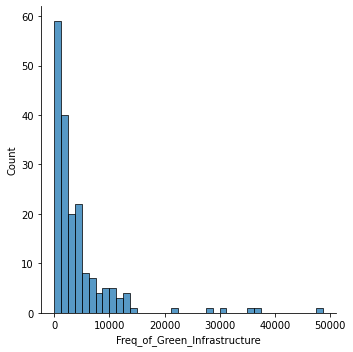

In [27]:
sns.displot(withGreen_Standardised, x="Freq_of_Green_Infrastructure")

In [28]:
print('mean =', withGreen_Standardised['Freq_of_Green_Infrastructure'].mean())
print('standard deviation =', withGreen_Standardised['Freq_of_Green_Infrastructure'].std())
print('skew =', withGreen_Standardised['Freq_of_Green_Infrastructure'].skew())
print('kurtosis =', withGreen_Standardised['Freq_of_Green_Infrastructure'].kurtosis())

mean = 4292.553572349743
standard deviation = 6444.566861289946
skew = 3.9539037890437463
kurtosis = 19.33856784497987


In [29]:
withGreen_Standardised.shape

(184, 53)

## Windsorise

In [30]:
from scipy.stats.mstats import winsorize
import statsmodels.api as sm

limit = 0.04
winsorized_x = withGreen_Standardised.copy()
winsorized_x['Freq_of_Green_Infrastructure'] = winsorize(withGreen_Standardised['Freq_of_Green_Infrastructure'], limits=limit)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
winsorized_x

,Urban Code 2018,NUTS3 2016,NUTS2 2016,City,City code,GDP,Employment,Population (1-5),Population (XXL - S-M),Population city,Population NUTS3,Region typology,Sights & landmarks,Museums & art galleries,Cinemas,Concert & music halls,Theatres,Tourist overnight stays,Museum visitors,Cinema attendance,Satisfaction with cultural facilities,"Jobs in arts, culture & entertainment",Jobs in media & communication,Jobs in other creative sectors,ICT patent applications,Community design applications,"Jobs in new arts, culture & entertainment enterprises",Jobs in new media & communication enterprises,Jobs in new enterprises in other creative sectors,Graduates in arts and humanities,Graduates in ICT,Average appearances in university rankings,Foreign graduates,Foreign-born population,Tolerance of foreigners,Integration of foreigners,People trust,Accessibility to passenger flights,Accessibility by road,Accessibility by rail,Quality of governance,OSM_Search_Query,Freq_of_Green_Natural,Freq_of_Green_Landuse,Freq_of_Green_Leisure,Country,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Type,Name,Freq_of_Green_Infrastructure
0,AT001C1,AT130,AT13,Vienna,1,2,3,1,XXL,1766746,1867582,MD,22.8927,21.6649,22.8952,37.8412,21.7561,30.5221,18.1269,49.2223,100,38.5724,34.1927,20.9087,10.7081,20.4087,28.2259,26.42,20.0704,8.222,15.9126,74.1936,51.2407,54.9822,35.1852,6.66667,40,23.5991,28.8663,65.5665,68.084,"Vienna, Austria",8169.71,882.017,159.559,AT,XXL,1,3,2,Festivals,Austria,9211.28
1,AT002C1,AT221,AT22,Graz,2,2,3,3,L,269997,434969,MD,39.3203,39.7809,25.3245,18.342,52.7229,14.8594,24.9029,24.6064,77.1429,36.4626,17.5588,26.945,75.9204,22.2448,17.5365,18.0342,14.0626,12.0959,42.6946,46.7742,29.3099,36.8327,40.7407,10,80,1.74195,23.6827,14.6005,65.947,"Graz, Austria",3083.37,886.677,148.15,AT,L,3,2,2,European Capital of Culture,Austria,4118.19
2,AT003C1,AT312,AT31,Linz,3,2,2,4,S-M,193814,581728,MD,13.5392,22.3246,23.2399,22.3578,21.0808,15.6626,16.5565,30.6358,57.1429,46.8533,49.8653,28.3243,26.6803,45.077,9.06506,13.1338,9.3376,7.81731,64.9194,17.7419,20.6154,40.2135,37.963,8.33333,60,2.3226,27.4413,18.2217,64.726,"Linz, Austria",11600.8,1675.32,160.979,AT,S-M,4,2,2,European Capital of Culture,Austria,13437.1
3,BE001C1,BE100,BE10,Brussels,4,1,4,1,XXL,1199095,1199095,MD,13.3981,26.5398,9.2506,13.4225,23.2416,21.2851,22.6863,26.0632,24.2857,50.9119,30.1408,26.8631,6.08708,15.5989,17.2207,26.4201,20.0703,27.6606,10.2498,48.3871,31.3388,77.758,20.3704,20,16.6667,34.7356,40.9759,35.843,47.068,"Brussels, Belgium",905.683,88.2332,59.8785,BE,XXL,1,4,1,European Capital of Culture,Belgium,1053.79
4,BE002C1,BE211,BE21,Antwerp,5,2,4,2,XL,520859,1041811,MD,9.76451,16.7462,11.2401,21.3928,32.6749,14.4578,21.3698,49.2223,48.5714,28.1955,14.3324,32.8002,58.7317,22.7748,14.9097,16.5419,18.5542,11.6292,8.00346,25.8065,23.611,50.1779,18.5185,13.3333,43.3333,77.2147,46.0058,22.0009,70.504,"Antwerp, Belgium",864.533,835.927,69.3086,BE,XL,2,3,2,European Capital of Culture,Belgium,1769.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,UK011C1,UKK11,UKK1,Bristol,191,3,1,3,L,457609,457635,MD,13.062,14.5399,24.8379,35.1718,18.7073,14.4578,17.9744,25.5391,51.4286,29.9242,35.1437,32.3646,46.951,18.7907,30.1168,65.4181,46.3334,21.2211,27.218,32.2581,65.6792,24.0214,54.9383,64.4444,70,45.5459,39.4667,12.3323,73.861,"Bristol, United Kingdom",575.601,429.187,87.8479,UK,L,3,1,3,UNESCO Creative City,United Kingdom,1092.64
180,UK029C1,UKF14,UKF1,Nottingham,162,3,4,3,L,326994,326963,MD,8.05172,18.2142,12.1786,18.9311,14.9301,22.49,16.1158,48.6509,25.7143,27.8214,30.5153,53.2727,12.4069,19.7916,19.7457,16.5511,14.7826,49.564,41.588,37.0968,62.4935,36.6548,54.9383,64.4444,70,46.3733,29.392,1.96904,68.847,"Nottingham, United Kingdom",1282.9,425.696,134.865,UK,L,3,4,3,UNESCO Creative City,Uni

In [32]:
winsorized_x.Type.value_counts()

European Capital of Culture    95
Festivals                      57
UNESCO Creative City           32
Name: Type, dtype: int64

In [33]:
winsorized_x["Population group\n(XXL - S-M)"].value_counts()

S-M    84
L      41
XL     39
XXL    20
Name: Population group\n(XXL - S-M), dtype: int64

In [34]:
Cultural_Creative_Cities_Monitor[~Cultural_Creative_Cities_Monitor.City.isin(winsorized_x.City)]

4,Urban Code 2018,NUTS3 2016,NUTS2 2016,City,City code,GDP,Employment,Population (1-5),Population (XXL - S-M),Population city,Population NUTS3,Region typology,Sights & landmarks,Museums & art galleries,Cinemas,Concert & music halls,Theatres,Tourist overnight stays,Museum visitors,Cinema attendance,Satisfaction with cultural facilities,"Jobs in arts, culture & entertainment",Jobs in media & communication,Jobs in other creative sectors,ICT patent applications,Community design applications,"Jobs in new arts, culture & entertainment enterprises",Jobs in new media & communication enterprises,Jobs in new enterprises in other creative sectors,Graduates in arts and humanities,Graduates in ICT,Average appearances in university rankings,Foreign graduates,Foreign-born population,Tolerance of foreigners,Integration of foreigners,People trust,Accessibility to passenger flights,Accessibility by road,Accessibility by rail,Quality of governance
53,DK002C1,DK042,DK04,Aarhus,44,3,2,3,L,319094,875084,MD,48.9888,21.6441,16.7011,21.3398,20.7723,7.22892,30.1713,32.2904,50,39.3129,32.3077,20.1353,17.2648,52.7171,0,2.52772,0,2.36238,6.57727,29.0323,32.9923,29.8932,88.8889,20,100,7.21539,28.3249,11.4503,85.285
54,DK003C1,DK031,DK03,Odense,176,3,3,4,S-M,193370,494049,MD,30.3718,57.8823,16.497,19.2078,36.0056,6.4257,19.1409,31.9667,8.57143,33.5011,21.0916,13.278,8.34911,31.2862,6.63085,15.2776,11.7701,22.6562,28.525,20.9677,29.8021,23.8434,88.8889,20,100,16.7487,31.0461,8.68326,79.049
71,ES510C1,ES212,ES21,San Sebastián-Donostia,52,3,4,4,S-M,186370,708991,MD,15.0204,13.2432,24.3246,29.8939,12.7716,36.5462,25.8762,26.5847,40,56.0388,11.7908,21.7861,7.47556,13.1332,8.46069,5.67993,13.2297,7.97796,4.05257,0,12.8834,15.6584,47.2222,33.3333,58.3333,6.62429,33.2196,17.9699,63.593
169,SE002C1,SE232,SE23,Gothenburg,150,2,1,2,XL,556640,1671783,MD,5.10663,9.94648,12.6297,12.233,20.0722,30.1205,17.9,28.6902,51.4286,35.6293,37.3756,27.0109,30.14,33.595,30.1168,55.1011,41.4527,0.22305,1.78092,50,5.57437,42.5267,73.1481,5,83.3333,7.31308,35.4195,11.5498,80.728
184,UK004C1,UKM82,UKM8,Glasgow,168,3,2,2,XL,618045,611177,MD,18.0979,23.9237,13.1148,30.0481,14.0919,17.2691,43.7647,28.5446,72.8571,38.279,28.9761,37.013,7.43163,3.80592,54.697,32.8743,54.0473,17.3626,35.9867,40.3226,71.3846,24.1993,57.4074,73.3333,100,19.8873,34.4723,100,70.656
193,UK550C1,UKM71,UKM7,Dundee,166,4,4,4,S-M,148490,265263,MD,23.6049,29.6962,22.6675,25.0132,16.7076,34.1365,18.8191,42.6889,8.57143,30.2144,19.5555,12.1985,7.33505,4.58673,18.3065,3.55151,12.4888,21.3514,39.3718,0,59.643,11.7438,54.9383,64.4444,70,26.4107,28.768,3.18962,70.656


In [35]:
print('mean =', winsorized_x['Freq_of_Green_Infrastructure'].mean())
print('standard deviation =', winsorized_x['Freq_of_Green_Infrastructure'].std())
print('skew =', winsorized_x['Freq_of_Green_Infrastructure'].skew())
print('kurtosis =', winsorized_x['Freq_of_Green_Infrastructure'].kurtosis())

mean = 3633.611727298501
standard deviation = 3658.526649421051
skew = 1.448321617092893
kurtosis = 1.1342501160708447


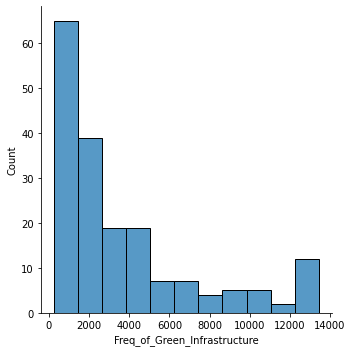

In [36]:
sns.displot(winsorized_x, x="Freq_of_Green_Infrastructure")

In [37]:
withGreen_Standardised = winsorized_x

## MinMax Normalise

In [38]:
from sklearn import preprocessing

# Create a dataframe only with the Green Infrastructure columns including the OSM_Search_Query column
green_columns_cities = withGreen_Standardised[['OSM_Search_Query',
                                        'Freq_of_Green_Infrastructure',
                                        'Freq_of_Green_Natural',
                                        'Freq_of_Green_Landuse',
                                        'Freq_of_Green_Leisure'
                                        ]]

print(green_columns_cities.shape) # what's is size?

# Remove the OSM_Search_Query column for the normalisation
green_columns = green_columns_cities[['Freq_of_Green_Infrastructure',
                                      'Freq_of_Green_Natural',
                                      'Freq_of_Green_Landuse',
                                      'Freq_of_Green_Leisure'                                      
                                        ]]

print(green_columns.shape) # what's is size?

x = green_columns.values # Returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler() # apply MinMax preprocessing
x_scaled = min_max_scaler.fit_transform(x) # apply MinMax function
green_MinMax = pd.DataFrame(x_scaled) # Create MinMax normalised Green Infrastructure dataframe
green_MinMax.columns = ['Freq_of_Green_Infrastructure_mm',
                        'Freq_of_Green_Natural_mm',
                        'Freq_of_Green_Landuse_mm',
                        'Freq_of_Green_Leisure_mm' 
                         ] # Add column names to the new dataframe

print(green_MinMax.shape) # what's is size?

green_MinMax = green_MinMax*100 # make sure everything is in out of 100, not 1

# Concat the Green Infrastructure dataframe with OSM_Search_Query column to the new MinMax normalised Green Infrastructure datafram
green_MinMax = pd.concat([green_columns_cities, 
                          green_MinMax], axis=1)

# green_MinMax = green_MinMax.dropna(how='any')

print(green_MinMax.shape) # what's is size?

green_MinMax.head(20)

(184, 5)
(184, 4)
(184, 4)
(184, 9)


,OSM_Search_Query,Freq_of_Green_Infrastructure,Freq_of_Green_Natural,Freq_of_Green_Landuse,Freq_of_Green_Leisure,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
0,"Vienna, Austria",9211.28,8169.71,882.017,159.559,67.929273,24.546117,2.982402,1.578453
1,"Graz, Austria",4118.19,3083.37,886.677,148.15,29.276677,9.247376,2.998197,1.460309
2,"Linz, Austria",13437.1,11600.8,1675.32,160.979,100.000000,34.866222,5.671615,1.593160
3,"Brussels, Belgium",1053.79,905.683,88.2332,59.8785,6.020271,2.697318,0.291550,0.546236
4,"Antwerp, Belgium",1769.77,864.533,835.927,69.3086,11.453957,2.573548,2.826160,0.643887
5,"Ghent, Belgium",4170.94,2103.97,1939.4,127.572,29.676966,6.301533,6.566822,1.247217
6,"Liège, Belgium",991.074,568.897,380.22,41.9571,5.544272,1.684330,1.281358,0.360655
7,"Bruges, Belgium",5023.1,2443.56,2192.7,386.847,36.144218,7.322948,7.425483,3.932085
8,"Namur, Belgium",494.1,344.7,132.3,17.1,1.772627,1.009990,0.440933,0.103253
9,"Leuven, Belgium",11607.8,4536.33,1096.95,5974.51,86.116871,13.617612,3.711001,61.793829


In [39]:
# Merge the MinMax normalised Green Infrastructure dataframe to the Standardised dataframe
withGreen_Standardised = withGreen_Standardised.merge(green_MinMax, on='OSM_Search_Query', how='inner')

print(withGreen_Standardised.shape)

withGreen_Standardised.head()

(184, 61)


,Urban Code 2018,NUTS3 2016,NUTS2 2016,City,City code,GDP,Employment,Population (1-5),Population (XXL - S-M),Population city,Population NUTS3,Region typology,Sights & landmarks,Museums & art galleries,Cinemas,Concert & music halls,Theatres,Tourist overnight stays,Museum visitors,Cinema attendance,Satisfaction with cultural facilities,"Jobs in arts, culture & entertainment",Jobs in media & communication,Jobs in other creative sectors,ICT patent applications,Community design applications,"Jobs in new arts, culture & entertainment enterprises",Jobs in new media & communication enterprises,Jobs in new enterprises in other creative sectors,Graduates in arts and humanities,Graduates in ICT,Average appearances in university rankings,Foreign graduates,Foreign-born population,Tolerance of foreigners,Integration of foreigners,People trust,Accessibility to passenger flights,Accessibility by road,Accessibility by rail,Quality of governance,OSM_Search_Query,Freq_of_Green_Natural_x,Freq_of_Green_Landuse_x,Freq_of_Green_Leisure_x,Country,Population group\n(XXL - S-M),Population group\n(1 - 5),Employment group,GDP group,Type,Name,Freq_of_Green_Infrastructure_x,Freq_of_Green_Infrastructure_y,Freq_of_Green_Natural_y,Freq_of_Green_Landuse_y,Freq_of_Green_Leisure_y,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
0,AT001C1,AT130,AT13,Vienna,1,2,3,1,XXL,1766746,1867582,MD,22.8927,21.6649,22.8952,37.8412,21.7561,30.5221,18.1269,49.2223,100,38.5724,34.1927,20.9087,10.7081,20.4087,28.2259,26.42,20.0704,8.222,15.9126,74.1936,51.2407,54.9822,35.1852,6.66667,40,23.5991,28.8663,65.5665,68.084,"Vienna, Austria",8169.71,882.017,159.559,AT,XXL,1,3,2,Festivals,Austria,9211.28,9211.28,8169.71,882.017,159.559,67.929273,24.546117,2.982402,1.578453
1,AT002C1,AT221,AT22,Graz,2,2,3,3,L,269997,434969,MD,39.3203,39.7809,25.3245,18.342,52.7229,14.8594,24.9029,24.6064,77.1429,36.4626,17.5588,26.945,75.9204,22.2448,17.5365,18.0342,14.0626,12.0959,42.6946,46.7742,29.3099,36.8327,40.7407,10,80,1.74195,23.6827,14.6005,65.947,"Graz, Austria",3083.37,886.677,148.15,AT,L,3,2,2,European Capital of Culture,Austria,4118.19,4118.19,3083.37,886.677,148.15,29.276677,9.247376,2.998197,1.460309
2,AT003C1,AT312,AT31,Linz,3,2,2,4,S-M,193814,581728,MD,13.5392,22.3246,23.2399,22.3578,21.0808,15.6626,16.5565,30.6358,57.1429,46.8533,49.8653,28.3243,26.6803,45.077,9.06506,13.1338,9.3376,7.81731,64.9194,17.7419,20.6154,40.2135,37.963,8.33333,60,2.3226,27.4413,18.2217,64.726,"Linz, Austria",11600.8,1675.32,160.979,AT,S-M,4,2,2,European Capital of Culture,Austria,13437.1,13437.1,11600.8,1675.32,160.979,100.000000,34.866222,5.671615,1.593160
3,BE001C1,BE100,BE10,Brussels,4,1,4,1,XXL,1199095,1199095,MD,13.3981,26.5398,9.2506,13.4225,23.2416,21.2851,22.6863,26.0632,24.2857,50.9119,30.1408,26.8631,6.08708,15.5989,17.2207,26.4201,20.0703,27.6606,10.2498,48.3871,31.3388,77.758,20.3704,20,16.6667,34.7356,40.9759,35.843,47.068,"Brussels, Belgium",905.683,88.2332,59.8785,BE,XXL,1,4,1,European Capital of Culture,Belgium,1053.79,1053.79,905.683,88.2332,59.8785,6.020271,2.697318,0.291550,0.546236
4,BE002C1,BE211,BE21,Antwerp,5,2,4,2,XL,520859,1041811,MD,9.76451,16.7462,11.2401,21.3928,32.6749,14.4578,21.3698,49.2223,48.5714,28.1955,14.3324,32.8002,58.7317,22.7748,14.9097,16.5419,18.5542,11.6292,8.00346,25.8065,23.611,50.1779,18.5185,13.3333,43.3333,77.2147,46.0058,22.0009,70.504,"Antwerp, Belgium",864.533,835.927,69.3086,BE,XL,2,3,2,European Capital of Culture,Belgium,1769.77,1769.77,864.533,835.927,69.3086,11.453957,2.573548,2.826160,0.643887


# Step 4 - Run some analysis


## 2019 Final Variables

In [40]:
# Read in Cities sheet from Cultural Creative Cities Monitor
CCCM_2019 = pd.read_excel('https://composite-indicators.jrc.ec.europa.eu/assets/c3/docs-and-data/2019/report-and-annexes/3CM2019_AnnexE.xlsx', 
                                                 sheet_name='2019 scores')

# Set the column labels to equal the values in the 2nd row (index location 1):
CCCM_2019.columns = CCCM_2019.iloc[2]

# Drop all blank columns
CCCM_2019 = CCCM_2019.dropna(how='all', axis=1)

# If the index has unique labels, drop the 2nd row
CCCM_2019 = CCCM_2019.drop(CCCM_2019.index[1])

CCCM_2019 = CCCM_2019.iloc[2:,:] # remove the first 4 rows

print(CCCM_2019.shape)

CCCM_2019.head()

(190, 22)


2,NUTS 3,Urban Code,City,City code,GDP,Employment,Population\n(1-5),Population\n(XXL - S-M),Region typology,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance
3,ES511,ES002C1,Barcelona,58,3,3,1,XXL,MD,31.15,28.19,29.38,40.61,25.05,31.33,43.11,15.69,22.48,43.84,38.73,36.92,40.81
4,DE300,DE001C1,Berlin,34,3,2,1,XXL,MD,33.98,31.58,36.59,33.56,22.34,40.83,36.63,22.16,43.76,29.36,26.23,54.59,62.66
5,UKG31,UK002C1,Birmingham,163,4,3,1,XXL,MD,20.44,16.73,13.66,41.45,9.77,23.69,19.33,4.25,12.69,22.34,57.98,37.45,74.06
6,BE100,BE001C1,Brussels,4,1,4,1,XXL,MD,24.64,20.19,25.05,32.73,16.47,23.91,35.97,10.84,21.24,28.77,33.23,37.18,47.07
7,RO321,RO001C1,Bucharest,145,2,3,1,XXL,MD,22.81,11.91,34.13,21.96,7.25,16.57,27.81,5.17,54.94,13.01,35.52,12.01,14.93


In [41]:
Greeninfrastructure_Mean = withGreen_Standardised[['City', 
                                                   'Freq_of_Green_Infrastructure_mm', 
                                                   'Freq_of_Green_Natural_mm',
                                                   'Freq_of_Green_Landuse_mm',
                                                   'Freq_of_Green_Leisure_mm', 
                                                   'Type', 
                                                   'OSM_Search_Query']]

Greeninfrastructure_Mean.shape

(184, 7)

In [42]:
withGreen_CCCM_2019 = CCCM_2019.merge(Greeninfrastructure_Mean, on='City', how='inner')

withGreen_CCCM_2019.head()

,NUTS 3,Urban Code,City,City code,GDP,Employment,Population\n(1-5),Population\n(XXL - S-M),Region typology,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm,Type,OSM_Search_Query
0,ES511,ES002C1,Barcelona,58,3,3,1,XXL,MD,31.15,28.19,29.38,40.61,25.05,31.33,43.11,15.69,22.48,43.84,38.73,36.92,40.81,6.172916,2.597963,0.321439,1.005272,UNESCO Creative City,"Barcelona, Spain"
1,DE300,DE001C1,Berlin,34,3,2,1,XXL,MD,33.98,31.58,36.59,33.56,22.34,40.83,36.63,22.16,43.76,29.36,26.23,54.59,62.66,38.415717,14.461595,1.301914,1.160469,European Capital of Culture,"Berlin, Germany"
2,UKG31,UK002C1,Birmingham,163,4,3,1,XXL,MD,20.44,16.73,13.66,41.45,9.77,23.69,19.33,4.25,12.69,22.34,57.98,37.45,74.06,70.402499,19.898136,0.979250,27.074249,Festivals,"Birmingham, United Kingdom"
3,BE100,BE001C1,Brussels,4,1,4,1,XXL,MD,24.64,20.19,25.05,32.73,16.47,23.91,35.97,10.84,21.24,28.77,33.23,37.18,47.07,6.020271,2.697318,0.291550,0.546236,European Capital of Culture,"Brussels, Belgium"
4,RO321,RO001C1,Bucharest,145,2,3,1,XXL,MD,22.81,11.91,34.13,21.96,7.25,16.57,27.81,5.17,54.94,13.01,35.52,12.01,14.93,22.267540,9.377142,0.156769,0.129608,European Capital of Culture,"Bucharest, Romania"


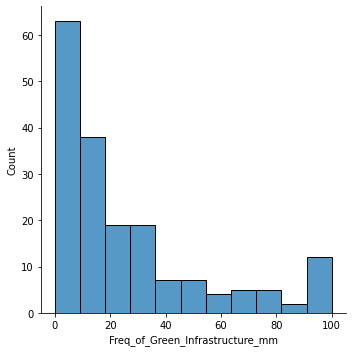

In [43]:
sns.displot(withGreen_CCCM_2019, x="Freq_of_Green_Infrastructure_mm")

In [44]:
cols = withGreen_CCCM_2019.columns.drop([
                                     'NUTS 3',
                                     'Urban Code'	,
                                     'City',
                                     'City code',
                                     'GDP',
                                     'Employment',
                                     'Population\n(1-5)',
                                     'Population\n(XXL - S-M)',
                                     'Region typology',
                                     'Type',
                                     'OSM_Search_Query'])

withGreen_CCCM_2019[cols] = withGreen_CCCM_2019[cols].apply(pd.to_numeric, errors='coerce')

In [45]:
withGreen_CCCM_2019.head()

,NUTS 3,Urban Code,City,City code,GDP,Employment,Population\n(1-5),Population\n(XXL - S-M),Region typology,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm,Type,OSM_Search_Query
0,ES511,ES002C1,Barcelona,58,3,3,1,XXL,MD,31.15,28.19,29.38,40.61,25.05,31.33,43.11,15.69,22.48,43.84,38.73,36.92,40.81,6.172916,2.597963,0.321439,1.005272,UNESCO Creative City,"Barcelona, Spain"
1,DE300,DE001C1,Berlin,34,3,2,1,XXL,MD,33.98,31.58,36.59,33.56,22.34,40.83,36.63,22.16,43.76,29.36,26.23,54.59,62.66,38.415717,14.461595,1.301914,1.160469,European Capital of Culture,"Berlin, Germany"
2,UKG31,UK002C1,Birmingham,163,4,3,1,XXL,MD,20.44,16.73,13.66,41.45,9.77,23.69,19.33,4.25,12.69,22.34,57.98,37.45,74.06,70.402499,19.898136,0.979250,27.074249,Festivals,"Birmingham, United Kingdom"
3,BE100,BE001C1,Brussels,4,1,4,1,XXL,MD,24.64,20.19,25.05,32.73,16.47,23.91,35.97,10.84,21.24,28.77,33.23,37.18,47.07,6.020271,2.697318,0.291550,0.546236,European Capital of Culture,"Brussels, Belgium"
4,RO321,RO001C1,Bucharest,145,2,3,1,XXL,MD,22.81,11.91,34.13,21.96,7.25,16.57,27.81,5.17,54.94,13.01,35.52,12.01,14.93,22.267540,9.377142,0.156769,0.129608,European Capital of Culture,"Bucharest, Romania"


## Correlation

In [71]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues


calculate_pvalues(withGreen_CCCM_2019)

,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
C3 Index,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0049,0.0614,0.7215,0.5919
1.\nCultural Vibrancy,0,0,0,0,0,0,0,0.0002,0.9381,0,0.0879,0.0051,0.0001,0,0.0017,0.6213,0.4112
2.\nCreative Economy,0,0,0,0,0.0281,0,0,0,0,0,0.0002,0,0,0.5616,0.7756,0.2066,0.5138
3.\nEnabling Environment,0,0,0,0,0.0172,0,0,0,0.0115,0,0,0,0,0.0515,0.3955,0.6404,0.0317
D1.1\nCultural Venues & Facilities,0,0,0.0281,0.0172,0,0,0,0.1775,0.0984,0.0003,0.6774,0.6418,0.0994,0,0.0003,0.2387,0.1595
D1.2\nCultural Participation & Attractiveness,0,0,0,0,0,0,0,0,0.0631,0.0003,0.0047,0,0,0.0044,0.0881,0.6388,0.9126
D2.1\nCreative & Knowledge-based Jobs,0,0,0,0,0,0,0,0,0.0049,0,0.0001,0,0,0.0689,0.0388,0.3508,0.5689
D2.2\nIntellectual Property & Innovation,0,0.0002,0,0,0.1775,0,0,0,0.0381,0.0001,0.0008,0,0,0.1064,0.4937,0.8977,0.747
D2.3\nNew Jobs in Creative Sectors,0,0.9381,0,0.0115,0.0984,0.0631,0.0049,0.0381,0,0.0855,0.2076,0.0004,0.1396,0.1465,0.087,0.196,0.0682
D3.1\nHuman Capital & Education,0,0,0,0,0.0003,0.0003,0,0.0001,0.0855,0,0.0457,0.0007,0.0001,0.0029,0.0908,0.0944,0.0108


In [46]:
withGreen_CCCM_2019.corr()

,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
C3 Index,1.000000,0.759097,0.851042,0.659231,0.569698,0.782432,0.816124,0.580670,0.448660,0.502195,0.399416,0.541800,0.515406,0.208291,0.139340,-0.026677,0.040105
1.\nCultural Vibrancy,0.759097,1.000000,0.361291,0.304876,0.900352,0.848612,0.551399,0.269487,-0.005817,0.306150,0.127229,0.207289,0.281674,0.308939,0.231858,0.036961,0.061451
2.\nCreative Economy,0.851042,0.361291,1.000000,0.492137,0.163210,0.503583,0.771696,0.620527,0.727551,0.343538,0.274198,0.542108,0.394905,0.043428,0.021332,-0.094324,-0.048839
3.\nEnabling Environment,0.659231,0.304876,0.492137,1.000000,0.176834,0.377401,0.494976,0.435269,0.187520,0.684469,0.780760,0.584419,0.668687,0.145004,0.063535,0.034955,0.159755
D1.1\nCultural Venues & Facilities,0.569698,0.900352,0.163210,0.176834,1.000000,0.533842,0.395122,0.100669,-0.123230,0.268997,0.031127,0.034804,0.122858,0.320581,0.266051,0.088010,0.104994
D1.2\nCultural Participation & Attractiveness,0.782432,0.848612,0.503583,0.377401,0.533842,1.000000,0.591129,0.401185,0.138448,0.267867,0.209337,0.360454,0.397949,0.210638,0.127144,-0.035126,-0.008215
D2.1\nCreative & Knowledge-based Jobs,0.816124,0.551399,0.771696,0.494976,0.395122,0.591129,1.000000,0.457331,0.208471,0.354293,0.284967,0.515190,0.363171,0.135528,0.153725,-0.069753,0.042621
D2.2\nIntellectual Property & Innovation,0.580670,0.269487,0.620527,0.435269,0.100669,0.401185,0.457331,1.000000,0.154292,0.293776,0.246576,0.424963,0.486837,0.120394,0.051194,-0.009625,0.024142
D2.3\nNew Jobs in Creative Sectors,0.448660,-0.005817,0.727551,0.187520,-0.123230,0.138448,0.208471,0.154292,1.000000,0.128194,0.094114,0.261656,0.110243,-0.108349,-0.127572,-0.096564,-0.135881
D3.1\nHuman Capital & Education,0.502195,0.306150,0.343538,0.684469,0.268997,0.267867,0.354293,0.293776,0.128194,1.000000,0.148750,0.250523,0.286030,0.220029,0.126079,0.124693,0.189048


In [47]:
withGreen_CCCM_2019[withGreen_CCCM_2019.Type == 'European Capital of Culture'].corr()

,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
C3 Index,1.000000,0.810511,0.844956,0.701344,0.652113,0.798659,0.802071,0.646149,0.482958,0.589793,0.354393,0.592533,0.547977,0.222852,0.154958,0.023603,-0.009496
1.\nCultural Vibrancy,0.810511,1.000000,0.415997,0.473131,0.913304,0.840917,0.558663,0.398415,0.052384,0.421207,0.227771,0.337832,0.432201,0.401830,0.298953,0.107732,0.190446
2.\nCreative Economy,0.844956,0.415997,1.000000,0.476778,0.230350,0.548547,0.796380,0.640226,0.769152,0.415553,0.160617,0.587557,0.363262,0.011759,-0.005367,-0.106822,-0.138949
3.\nEnabling Environment,0.701344,0.473131,0.476778,1.000000,0.398888,0.442017,0.469002,0.498130,0.191773,0.751456,0.733699,0.517717,0.663349,0.102984,0.061582,0.137207,-0.123222
D1.1\nCultural Venues & Facilities,0.652113,0.913304,0.230350,0.398888,1.000000,0.547609,0.413756,0.228490,-0.067708,0.421321,0.180774,0.178148,0.295155,0.443377,0.344938,0.187947,0.232560
D1.2\nCultural Participation & Attractiveness,0.798659,0.840917,0.548547,0.442017,0.547609,1.000000,0.597970,0.514875,0.197566,0.305535,0.227744,0.457335,0.495811,0.236474,0.155895,-0.028382,0.082313
D2.1\nCreative & Knowledge-based Jobs,0.802071,0.558663,0.796380,0.469002,0.413756,0.597970,1.000000,0.480926,0.301790,0.371009,0.201532,0.560879,0.351479,0.127381,0.120851,-0.054069,0.037806
D2.2\nIntellectual Property & Innovation,0.646149,0.398415,0.640226,0.498130,0.228490,0.514875,0.480926,1.000000,0.225660,0.350720,0.255667,0.533670,0.495650,0.148073,0.085378,-0.013517,-0.087106
D2.3\nNew Jobs in Creative Sectors,0.482958,0.052384,0.769152,0.191773,-0.067708,0.197566,0.301790,0.225660,1.000000,0.242049,-0.017603,0.291252,0.093765,-0.165498,-0.159352,-0.136938,-0.239734
D3.1\nHuman Capital & Education,0.589793,0.421207,0.415553,0.751456,0.421321,0.305535,0.371009,0.350720,0.242049,1.000000,0.177181,0.341781,0.359382,0.172656,0.154656,0.200772,-0.093756


In [48]:
withGreen_CCCM_2019[withGreen_CCCM_2019.Type == 'UNESCO Creative City'].corr()

,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
C3 Index,1.000000,0.668073,0.772546,0.659223,0.388980,0.723509,0.681719,0.333742,0.368668,0.611412,0.400266,0.446807,0.247062,0.079746,0.179379,-0.077353,0.173044
1.\nCultural Vibrancy,0.668073,1.000000,0.158451,0.195886,0.837478,0.807595,0.464099,0.151026,-0.193680,0.346684,0.008605,0.068470,0.051558,0.058737,0.087822,-0.017732,0.104322
2.\nCreative Economy,0.772546,0.158451,1.000000,0.386636,-0.086555,0.364532,0.601096,0.346443,0.716828,0.358428,0.203175,0.463439,0.028743,-0.080329,0.009726,-0.121995,-0.028273
3.\nEnabling Environment,0.659223,0.195886,0.386636,1.000000,0.023861,0.309442,0.314922,0.182938,0.196604,0.681443,0.823332,0.445650,0.596623,0.276019,0.376536,-0.000365,0.395305
D1.1\nCultural Venues & Facilities,0.388980,0.837478,-0.086555,0.023861,1.000000,0.354068,0.306001,-0.075324,-0.300893,0.142830,-0.027296,-0.162659,-0.050790,-0.011295,0.141966,-0.184500,0.206123
D1.2\nCultural Participation & Attractiveness,0.723509,0.807595,0.364532,0.309442,0.354068,1.000000,0.464126,0.339727,-0.006870,0.439118,0.044165,0.292747,0.142943,0.112709,-0.002947,0.168808,-0.043947
D2.1\nCreative & Knowledge-based Jobs,0.681719,0.464099,0.601096,0.314922,0.306001,0.464126,1.000000,0.196014,-0.024500,0.425666,0.088965,0.312973,-0.058931,-0.130843,0.055329,-0.258622,0.060599
D2.2\nIntellectual Property & Innovation,0.333742,0.151026,0.346443,0.182938,-0.075324,0.339727,0.196014,1.000000,-0.119838,0.181491,-0.007490,0.367293,0.397677,0.194379,0.072206,0.229558,-0.067019
D2.3\nNew Jobs in Creative Sectors,0.368668,-0.193680,0.716828,0.196604,-0.300893,-0.006870,-0.024500,-0.119838,1.000000,0.080806,0.202832,0.218789,-0.090563,-0.093275,-0.058280,-0.070235,-0.051758
D3.1\nHuman Capital & Education,0.611412,0.346684,0.358428,0.681443,0.142830,0.439118,0.425666,0.181491,0.080806,1.000000,0.182799,0.266411,0.191093,0.266040,0.267505,0.116979,0.306890


In [49]:
withGreen_CCCM_2019[withGreen_CCCM_2019.Type == 'Festivals'].corr()

,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
C3 Index,1.000000,0.707611,0.873973,0.581026,0.516555,0.769513,0.869986,0.534300,0.420000,0.308279,0.455275,0.439057,0.513604,0.269144,0.137602,-0.139018,-0.007230
1.\nCultural Vibrancy,0.707611,1.000000,0.326073,0.073913,0.909699,0.891526,0.585392,0.111305,-0.043437,0.084660,0.014062,0.046470,0.119150,0.207345,0.155745,-0.134909,-0.071289
2.\nCreative Economy,0.873973,0.326073,1.000000,0.537214,0.150853,0.449657,0.764908,0.651168,0.679440,0.231562,0.447363,0.437892,0.512974,0.180276,0.092065,-0.051925,-0.022793
3.\nEnabling Environment,0.581026,0.073913,0.537214,1.000000,-0.114190,0.263746,0.559920,0.418363,0.181935,0.569488,0.811094,0.693772,0.667632,0.261852,0.025373,-0.180610,0.183725
D1.1\nCultural Venues & Facilities,0.516555,0.909699,0.150853,-0.114190,1.000000,0.622917,0.461608,-0.027508,-0.158072,0.044074,-0.180987,-0.091296,-0.070631,0.139407,0.133946,-0.132447,-0.042690
D1.2\nCultural Participation & Attractiveness,0.769513,0.891526,0.449657,0.263746,0.622917,1.000000,0.599285,0.239556,0.090538,0.111412,0.223847,0.187096,0.301426,0.238654,0.147396,-0.109486,-0.087708
D2.1\nCreative & Knowledge-based Jobs,0.869986,0.585392,0.764908,0.559920,0.461608,0.599285,1.000000,0.463744,0.140178,0.293951,0.441786,0.439150,0.456228,0.301742,0.279904,-0.047148,0.023972
D2.2\nIntellectual Property & Innovation,0.534300,0.111305,0.651168,0.418363,-0.027508,0.239556,0.463744,1.000000,0.142809,0.247331,0.310483,0.255630,0.482363,0.085308,0.024967,-0.055443,0.176777
D2.3\nNew Jobs in Creative Sectors,0.420000,-0.043437,0.679440,0.181935,-0.158072,0.090538,0.140178,0.142809,1.000000,-0.010883,0.196948,0.214249,0.201286,-0.016783,-0.118897,-0.015712,-0.166115
D3.1\nHuman Capital & Education,0.308279,0.084660,0.231562,0.569488,0.044074,0.111412,0.293951,0.247331,-0.010883,1.000000,0.037755,0.093623,0.199827,0.374084,0.080706,-0.051552,0.400541


In [50]:
withGreen_CCCM_2019['Population\n(XXL - S-M)'].value_counts()

S-M    84
L      40
XL     37
XXL    20
Name: Population\n(XXL - S-M), dtype: int64

In [51]:
withGreen_CCCM_2019[withGreen_CCCM_2019['Population\n(XXL - S-M)'] == 'XXL'].corr()

,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
C3 Index,1.000000,0.836357,0.878561,0.577365,0.775659,0.739567,0.856242,0.720313,0.503702,0.795736,0.050783,0.607491,0.255017,0.187084,0.270441,0.025398,-0.213550
1.\nCultural Vibrancy,0.836357,1.000000,0.529012,0.443747,0.920175,0.892849,0.664889,0.539464,0.123932,0.772602,-0.128803,0.476418,0.308821,0.296862,0.328378,0.206128,-0.105790
2.\nCreative Economy,0.878561,0.529012,1.000000,0.293844,0.533693,0.418091,0.808422,0.700154,0.773842,0.550357,-0.095048,0.368377,-0.035633,-0.003127,0.094846,-0.020449,-0.355264
3.\nEnabling Environment,0.577365,0.443747,0.293844,1.000000,0.307738,0.511738,0.443055,0.357572,-0.022251,0.653317,0.759223,0.869769,0.669960,0.286694,0.343446,-0.239810,0.192457
D1.1\nCultural Venues & Facilities,0.775659,0.920175,0.533693,0.307738,1.000000,0.645260,0.691823,0.408445,0.164769,0.781300,-0.279550,0.318357,0.100392,0.161188,0.145685,0.248358,-0.056369
D1.2\nCultural Participation & Attractiveness,0.739567,0.892849,0.418091,0.511738,0.645260,1.000000,0.501517,0.582604,0.051985,0.608762,0.070063,0.563370,0.487060,0.393880,0.473226,0.116446,-0.141557
D2.1\nCreative & Knowledge-based Jobs,0.856242,0.664889,0.808422,0.443055,0.691823,0.501517,1.000000,0.602466,0.299567,0.739902,-0.060565,0.500951,0.045098,-0.027057,0.077317,-0.188740,-0.244337
D2.2\nIntellectual Property & Innovation,0.720313,0.539464,0.700154,0.357572,0.408445,0.582604,0.602466,1.000000,0.289002,0.383911,0.071751,0.391877,0.416117,0.109315,0.154747,0.139117,-0.224049
D2.3\nNew Jobs in Creative Sectors,0.503702,0.123932,0.773842,-0.022251,0.164769,0.051985,0.299567,0.289002,1.000000,0.162308,-0.147858,0.045259,-0.284303,-0.028638,0.034678,0.072035,-0.324049
D3.1\nHuman Capital & Education,0.795736,0.772602,0.550357,0.653317,0.781300,0.608762,0.739902,0.383911,0.162308,1.000000,0.040453,0.581572,0.143900,0.099917,0.122328,0.032554,-0.047273


In [52]:
withGreen_CCCM_2019[withGreen_CCCM_2019['Population\n(XXL - S-M)'] == 'XL'].corr()

,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
C3 Index,1.000000,0.845162,0.897135,0.652329,0.630552,0.875827,0.730434,0.519561,0.497802,0.461707,0.435700,0.338038,0.543977,0.073371,0.137285,-0.131900,0.086874
1.\nCultural Vibrancy,0.845162,1.000000,0.581743,0.508823,0.892496,0.885295,0.612059,0.308709,0.226592,0.482054,0.220559,0.387583,0.348815,0.017037,0.130299,-0.245384,0.089357
2.\nCreative Economy,0.897135,0.581743,1.000000,0.390266,0.307444,0.733342,0.666855,0.562222,0.681029,0.244635,0.273563,0.173762,0.450029,0.053107,0.020651,0.005933,-0.068423
3.\nEnabling Environment,0.652329,0.508823,0.390266,1.000000,0.450530,0.454244,0.455864,0.318460,0.059533,0.577426,0.841853,0.376076,0.644567,0.159024,0.328339,-0.172346,0.405049
D1.1\nCultural Venues & Facilities,0.630552,0.892496,0.307444,0.450530,1.000000,0.580367,0.473638,0.056012,0.054111,0.538133,0.144796,0.281322,0.162497,0.038103,0.212401,-0.303010,0.227854
D1.2\nCultural Participation & Attractiveness,0.875827,0.885295,0.733342,0.454244,0.580367,1.000000,0.616704,0.499495,0.353399,0.315714,0.248894,0.409728,0.462177,-0.008576,0.016221,-0.130642,-0.073588
D2.1\nCreative & Knowledge-based Jobs,0.730434,0.612059,0.666855,0.455864,0.473638,0.616704,1.000000,0.384257,0.006302,0.123496,0.391956,0.484738,0.437976,-0.141679,0.034604,-0.398128,0.035769
D2.2\nIntellectual Property & Innovation,0.519561,0.308709,0.562222,0.318460,0.056012,0.499495,0.384257,1.000000,0.029429,0.047917,0.295557,0.252607,0.502797,0.008271,-0.016703,0.020985,-0.055853
D2.3\nNew Jobs in Creative Sectors,0.497802,0.226592,0.681029,0.059533,0.054111,0.353399,0.006302,0.029429,1.000000,0.243553,-0.052661,-0.254361,0.070046,0.188303,0.011691,0.315881,-0.102802
D3.1\nHuman Capital & Education,0.461707,0.482054,0.244635,0.577426,0.538133,0.315714,0.123496,0.047917,0.243553,1.000000,0.096667,-0.153615,0.031566,0.356862,0.333478,0.198967,0.329898


In [53]:
withGreen_CCCM_2019[withGreen_CCCM_2019['Population\n(XXL - S-M)'] == 'L'].corr()

,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
C3 Index,1.000000,0.778527,0.850658,0.565493,0.688799,0.794357,0.838021,0.586070,0.333954,0.391832,0.320469,0.514671,0.488587,0.233586,0.228294,0.025889,-0.200126
1.\nCultural Vibrancy,0.778527,1.000000,0.389883,0.141483,0.955118,0.937995,0.608619,0.280249,-0.065078,0.239562,-0.062535,0.184908,0.156680,0.381121,0.407986,-0.128872,-0.116079
2.\nCreative Economy,0.850658,0.389883,1.000000,0.487811,0.292647,0.459065,0.752505,0.618256,0.654326,0.223740,0.337118,0.516868,0.458235,0.061909,0.044982,0.119986,-0.198812
3.\nEnabling Environment,0.565493,0.141483,0.487811,1.000000,0.080043,0.197033,0.485738,0.469755,0.105221,0.622998,0.760846,0.614365,0.700783,-0.021125,-0.068044,0.139504,-0.141074
D1.1\nCultural Venues & Facilities,0.688799,0.955118,0.292647,0.080043,1.000000,0.793211,0.553378,0.200335,-0.133487,0.303989,-0.176734,0.119978,0.074108,0.419142,0.493990,-0.179691,-0.049940
D1.2\nCultural Participation & Attractiveness,0.794357,0.937995,0.459065,0.197033,0.793211,1.000000,0.603663,0.341620,0.022442,0.136666,0.078146,0.239609,0.235227,0.293024,0.260591,-0.054440,-0.180230
D2.1\nCreative & Knowledge-based Jobs,0.838021,0.608619,0.752505,0.485738,0.553378,0.603663,1.000000,0.429680,0.106365,0.330796,0.324366,0.328925,0.402967,0.240139,0.241974,0.010741,-0.068681
D2.2\nIntellectual Property & Innovation,0.586070,0.280249,0.618256,0.469755,0.200335,0.341620,0.429680,1.000000,0.061529,0.253945,0.256823,0.540152,0.560687,0.225279,0.162245,0.309424,-0.153611
D2.3\nNew Jobs in Creative Sectors,0.333954,-0.065078,0.654326,0.105221,-0.133487,0.022442,0.106365,0.061529,1.000000,-0.076626,0.124645,0.260152,0.076162,-0.255356,-0.248127,0.009948,-0.187349
D3.1\nHuman Capital & Education,0.391832,0.239562,0.223740,0.622998,0.303989,0.136666,0.330796,0.253945,-0.076626,1.000000,0.047927,0.211101,0.361596,0.196314,0.139310,0.248806,-0.063396


In [54]:
withGreen_CCCM_2019[withGreen_CCCM_2019['Population\n(XXL - S-M)'] == 'S-M'].corr()

,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm
C3 Index,1.000000,0.838465,0.800276,0.675192,0.661472,0.783899,0.786097,0.524406,0.244787,0.397680,0.526875,0.474373,0.625366,0.358547,0.162352,0.065302,0.112157
1.\nCultural Vibrancy,0.838465,1.000000,0.411128,0.371348,0.886156,0.812548,0.593168,0.248587,-0.074528,0.246949,0.280060,0.210081,0.346161,0.336869,0.180937,0.058505,0.096096
2.\nCreative Economy,0.800276,0.411128,1.000000,0.476214,0.219191,0.516685,0.770834,0.612794,0.571552,0.178701,0.370735,0.553542,0.568271,0.221872,0.094436,-0.021616,0.073848
3.\nEnabling Environment,0.675192,0.371348,0.476214,1.000000,0.264700,0.382756,0.424843,0.433695,0.116409,0.707315,0.803271,0.426322,0.695534,0.277716,0.073684,0.167246,0.099723
D1.1\nCultural Venues & Facilities,0.661472,0.886156,0.219191,0.264700,1.000000,0.449938,0.417012,0.110674,-0.139456,0.216273,0.206244,0.046463,0.190654,0.327959,0.204447,0.097764,0.097975
D1.2\nCultural Participation & Attractiveness,0.783899,0.812548,0.516685,0.382756,0.449938,1.000000,0.618721,0.339854,0.031797,0.203901,0.280332,0.346520,0.427357,0.236731,0.091601,-0.010193,0.061988
D2.1\nCreative & Knowledge-based Jobs,0.786097,0.593168,0.770834,0.424843,0.417012,0.618721,1.000000,0.404260,0.026248,0.214044,0.300385,0.480188,0.433243,0.328019,0.245256,0.046661,0.171946
D2.2\nIntellectual Property & Innovation,0.524406,0.248587,0.612794,0.433695,0.110674,0.339854,0.404260,1.000000,0.028035,0.350230,0.226216,0.369851,0.448798,0.202269,0.059239,0.008553,0.214849
D2.3\nNew Jobs in Creative Sectors,0.244787,-0.074528,0.571552,0.116409,-0.139456,0.031797,0.026248,0.028035,1.000000,-0.137723,0.196064,0.236480,0.265972,-0.092659,-0.141448,-0.097753,-0.195973
D3.1\nHuman Capital & Education,0.397680,0.246949,0.178701,0.707315,0.216273,0.203901,0.214044,0.350230,-0.137723,1.000000,0.215972,0.076019,0.388288,0.305819,0.129791,0.238529,0.260904


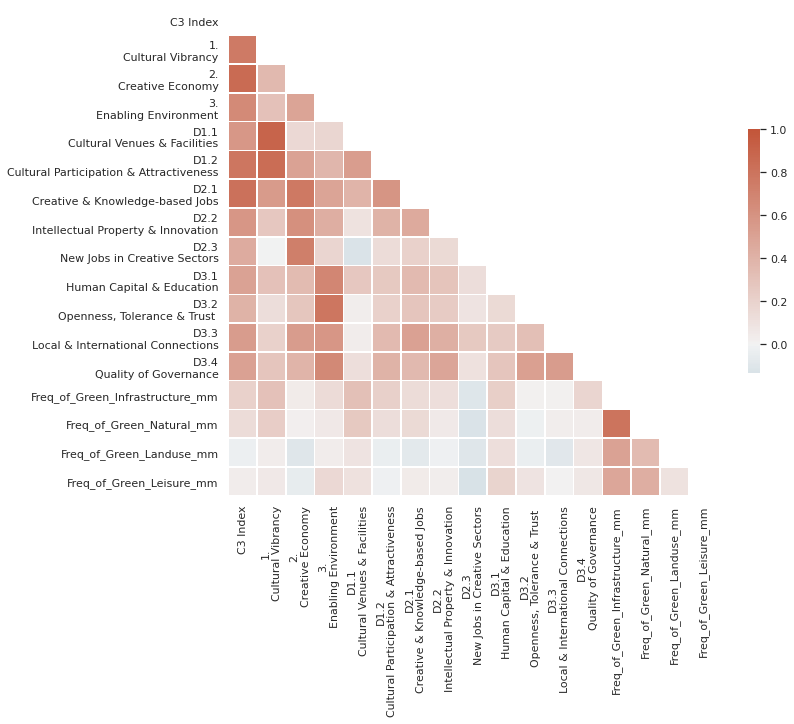

In [55]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = withGreen_CCCM_2019.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [56]:
withGreen_CCCM_2019.head()

,NUTS 3,Urban Code,City,City code,GDP,Employment,Population\n(1-5),Population\n(XXL - S-M),Region typology,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm,Type,OSM_Search_Query
0,ES511,ES002C1,Barcelona,58,3,3,1,XXL,MD,31.15,28.19,29.38,40.61,25.05,31.33,43.11,15.69,22.48,43.84,38.73,36.92,40.81,6.172916,2.597963,0.321439,1.005272,UNESCO Creative City,"Barcelona, Spain"
1,DE300,DE001C1,Berlin,34,3,2,1,XXL,MD,33.98,31.58,36.59,33.56,22.34,40.83,36.63,22.16,43.76,29.36,26.23,54.59,62.66,38.415717,14.461595,1.301914,1.160469,European Capital of Culture,"Berlin, Germany"
2,UKG31,UK002C1,Birmingham,163,4,3,1,XXL,MD,20.44,16.73,13.66,41.45,9.77,23.69,19.33,4.25,12.69,22.34,57.98,37.45,74.06,70.402499,19.898136,0.979250,27.074249,Festivals,"Birmingham, United Kingdom"
3,BE100,BE001C1,Brussels,4,1,4,1,XXL,MD,24.64,20.19,25.05,32.73,16.47,23.91,35.97,10.84,21.24,28.77,33.23,37.18,47.07,6.020271,2.697318,0.291550,0.546236,European Capital of Culture,"Brussels, Belgium"
4,RO321,RO001C1,Bucharest,145,2,3,1,XXL,MD,22.81,11.91,34.13,21.96,7.25,16.57,27.81,5.17,54.94,13.01,35.52,12.01,14.93,22.267540,9.377142,0.156769,0.129608,European Capital of Culture,"Bucharest, Romania"


181 181


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


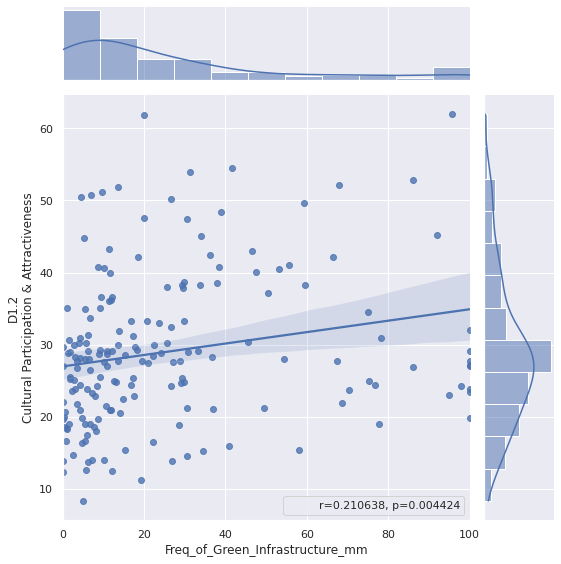

In [57]:
import seaborn as sns
import scipy.stats as stats

df = withGreen_CCCM_2019
x = 'Freq_of_Green_Infrastructure_mm'
y = "D1.2\nCultural Participation & Attractiveness"
print(len(df[x]), len(df[y]))

sns.set(style="darkgrid", color_codes=True)
graph = sns.jointplot(x, y, data=df, kind='reg', height=8)

r, p = stats.pearsonr(df[x], df[y])
phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0) # if you choose to write your own legend, then you should adjust the properties then
graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)]) # here graph is not a ax but a joint grid, so we access the axis through ax_joint method

In [58]:
df.head()

,NUTS 3,Urban Code,City,City code,GDP,Employment,Population\n(1-5),Population\n(XXL - S-M),Region typology,C3 Index,1.\nCultural Vibrancy,2.\nCreative Economy,3.\nEnabling Environment,D1.1\nCultural Venues & Facilities,D1.2\nCultural Participation & Attractiveness,D2.1\nCreative & Knowledge-based Jobs,D2.2\nIntellectual Property & Innovation,D2.3\nNew Jobs in Creative Sectors,D3.1\nHuman Capital & Education,"D3.2\nOpenness, Tolerance & Trust",D3.3\nLocal & International Connections,D3.4\nQuality of Governance,Freq_of_Green_Infrastructure_mm,Freq_of_Green_Natural_mm,Freq_of_Green_Landuse_mm,Freq_of_Green_Leisure_mm,Type,OSM_Search_Query
0,ES511,ES002C1,Barcelona,58,3,3,1,XXL,MD,31.15,28.19,29.38,40.61,25.05,31.33,43.11,15.69,22.48,43.84,38.73,36.92,40.81,6.172916,2.597963,0.321439,1.005272,UNESCO Creative City,"Barcelona, Spain"
1,DE300,DE001C1,Berlin,34,3,2,1,XXL,MD,33.98,31.58,36.59,33.56,22.34,40.83,36.63,22.16,43.76,29.36,26.23,54.59,62.66,38.415717,14.461595,1.301914,1.160469,European Capital of Culture,"Berlin, Germany"
2,UKG31,UK002C1,Birmingham,163,4,3,1,XXL,MD,20.44,16.73,13.66,41.45,9.77,23.69,19.33,4.25,12.69,22.34,57.98,37.45,74.06,70.402499,19.898136,0.979250,27.074249,Festivals,"Birmingham, United Kingdom"
3,BE100,BE001C1,Brussels,4,1,4,1,XXL,MD,24.64,20.19,25.05,32.73,16.47,23.91,35.97,10.84,21.24,28.77,33.23,37.18,47.07,6.020271,2.697318,0.291550,0.546236,European Capital of Culture,"Brussels, Belgium"
4,RO321,RO001C1,Bucharest,145,2,3,1,XXL,MD,22.81,11.91,34.13,21.96,7.25,16.57,27.81,5.17,54.94,13.01,35.52,12.01,14.93,22.267540,9.377142,0.156769,0.129608,European Capital of Culture,"Bucharest, Romania"


In [59]:
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


AttributeError: ignored

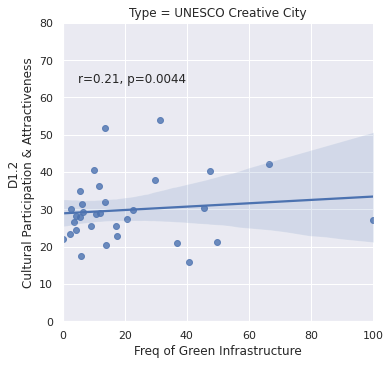

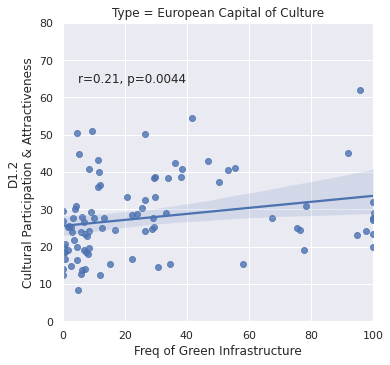

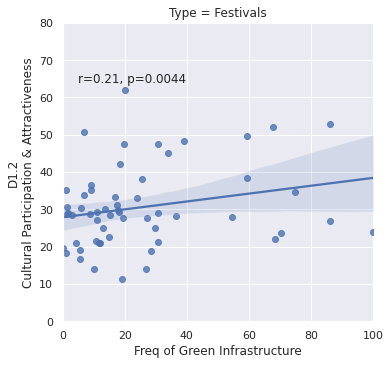

In [60]:
import scipy as sp

df = withGreen_CCCM_2019
x = 'Freq_of_Green_Infrastructure_mm'
y = "D1.2\nCultural Participation & Attractiveness"

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(df[x], df[y])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)

type_list = ['UNESCO Creative City','European Capital of Culture','Festivals']

#def Get_Dataset(data):
for i in type_list:
  dataset = df.loc[df['Type']==i]
  g = sns.lmplot(x=x, y=y, data=dataset, hue='Type', col="Type", height=5, aspect=1, x_jitter=.1)
  g.map_dataframe(annotate)
  g = (g.set_axis_labels("Freq of Green Infrastructure", "D1.2\nCultural Participation & Attractiveness")
      .set(xlim=(0, 100), ylim=(0, 80))
      .fig.subplots_adjust(wspace=.1))

g.map_dataframe(annotate)

plt.show()

In [ ]:
import scipy as sp

df = withGreen_CCCM_2019
x = 'Freq_of_Green_Infrastructure_mm'
y = "1.\nCultural Vibrancy"

g = sns.lmplot(x=x, y=y, hue="Type", data=df, col="Type", height=5, aspect=1, x_jitter=.1)

# def annotate(data, **kws):
#     r, p = sp.stats.pearsonr(df[x], df[y])
#     ax = plt.gca()
#     ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)
    
# g.map_dataframe(annotate)

g = (g.set_axis_labels("Freq of Green Infrastructure", "1. Cultural Vibrancy")
      .set(xlim=(0, 100), ylim=(0, 80))
      .fig.subplots_adjust(wspace=.1))

plt.show()

In [ ]:
import scipy as sp

df = withGreen_CCCM_2019
x = 'Freq_of_Green_Infrastructure_mm'
y = "3.\nEnabling Environment"

g = sns.lmplot(x=x, y=y, hue="Type", data=df, col="Type", height=5, aspect=1, x_jitter=.1)

# def annotate(data, **kws):
#     r, p = sp.stats.pearsonr(df[x], df[y])
#     ax = plt.gca()
#     ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)
    
# g.map_dataframe(annotate)

g = (g.set_axis_labels("Freq of Green Infrastructure", "3. Enabling Environment")
      .set(xlim=(0, 100), ylim=(0, 80))
      .fig.subplots_adjust(wspace=.1))

plt.show()

In [ ]:
df = withGreen_CCCM_2019
x = 'Freq_of_Green_Infrastructure_mm'
y = "1.\nCultural Vibrancy"

g = sns.lmplot(x=x, y=y, hue="Population\n(XXL - S-M)", col="Population\n(XXL - S-M)", data=df, height=5, aspect=1, x_jitter=.1)

# def annotate(data, **kws):
#     r, p = sp.stats.pearsonr(df[x], df[y])
#     ax = plt.gca()
#     ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)
    
# g.map_dataframe(annotate)

g = (g.set_axis_labels("Freq of Green Infrastructure", "1. Cultural Vibrancy")
      .set(xlim=(0, 100), ylim=(0, 80))
      .fig.subplots_adjust(wspace=.1))

plt.show()

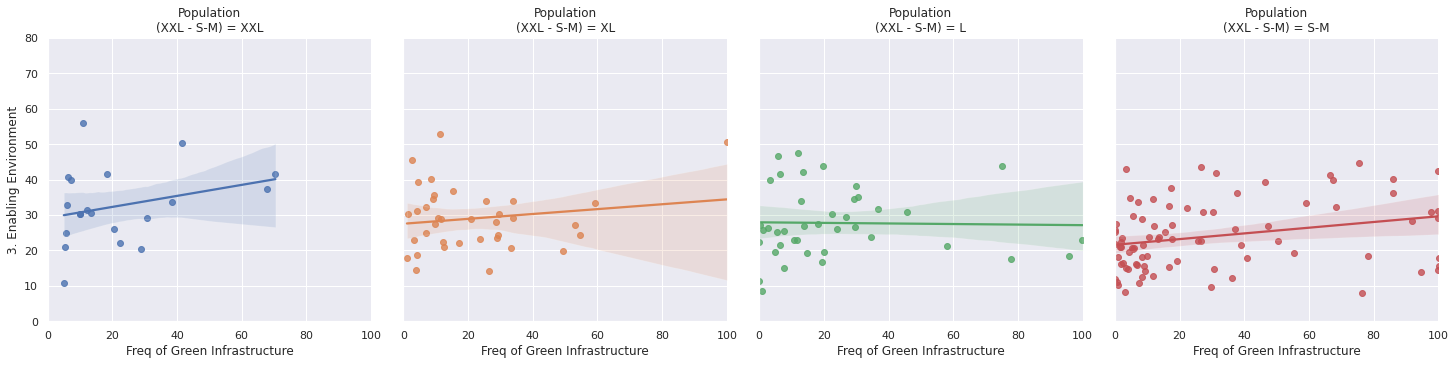

In [ ]:
df = withGreen_CCCM_2019
x = 'Freq_of_Green_Infrastructure_mm'
y = "3.\nEnabling Environment"

g = sns.lmplot(x=x, y=y, hue="Population\n(XXL - S-M)", col="Population\n(XXL - S-M)", data=df, height=5, aspect=1, x_jitter=.1)

# def annotate(data, **kws):
#     r, p = sp.stats.pearsonr(df[x], df[y])
#     ax = plt.gca()
#     ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)
    
# g.map_dataframe(annotate)

g = (g.set_axis_labels("Freq of Green Infrastructure", "3. Enabling Environment")
      .set(xlim=(0, 100), ylim=(0, 80))
      .fig.subplots_adjust(wspace=.1))

plt.show()

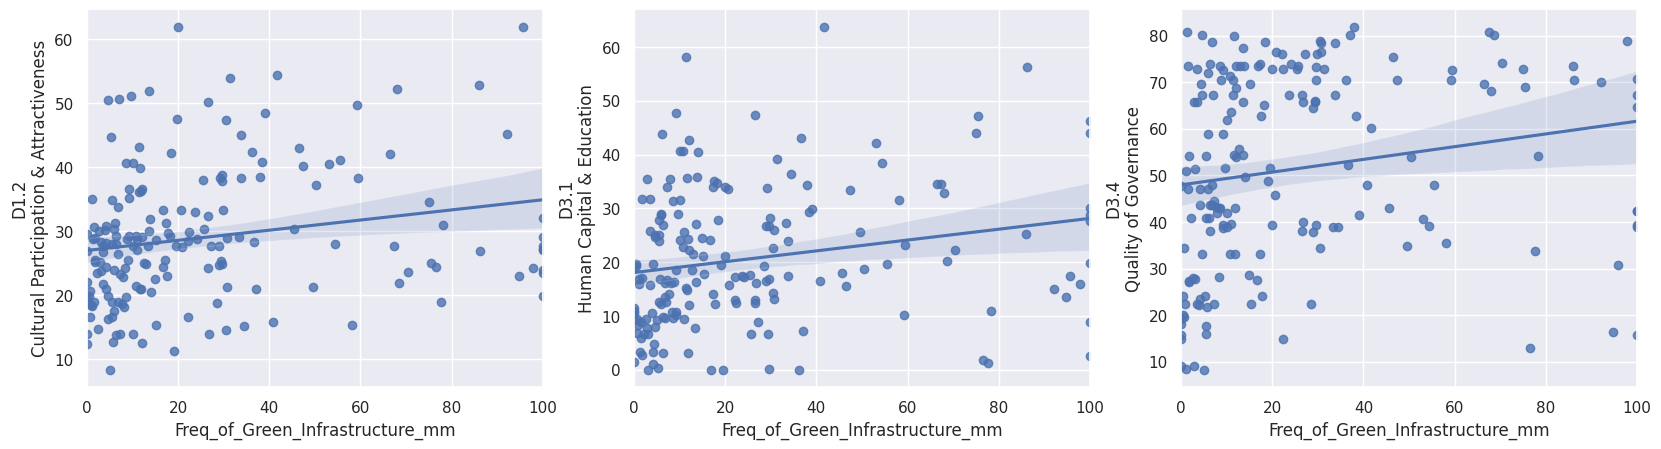

In [ ]:
# Linear - Line of best fit
import seaborn as sns
df=withGreen_CCCM_2019
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})

fig, axs = plt.subplots(ncols=3)

sns.regplot(x='Freq_of_Green_Infrastructure_mm', 
           y='D1.2\nCultural Participation & Attractiveness', 
          #  hue='Type', 
           data=df,
           ax=axs[0])

sns.regplot(x='Freq_of_Green_Infrastructure_mm', 
            y='D3.1\nHuman Capital & Education', 
          #  hue='Type', 
           data=df,
           ax=axs[1])

sns.regplot(x='Freq_of_Green_Infrastructure_mm', 
            y='D3.4\nQuality of Governance', 
          #  hue='Type', 
           data=df,
           ax=axs[2])

In [ ]:
# Linear - Line of best fit
import seaborn as sns
df=withGreen_CCCM_2019
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='Freq_of_Green_Infrastructure_mm', y='D1.2\nCultural Participation & Attractiveness', hue='Type', data=df);

In [ ]:
# Linear - Line of best fit
import seaborn as sns
df=withGreen_CCCM_2019
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='Freq_of_Green_Infrastructure_mm', y='D1.2\nCultural Participation & Attractiveness', hue='Population\n(XXL - S-M)', data=df);

In [ ]:
# Linear - Line of best fit
import seaborn as sns
df=withGreen_CCCM_2019
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='Freq_of_Green_Infrastructure_mm', y='D1.2\nCultural Participation & Attractiveness', hue='GDP', data=df);

In [ ]:
# Linear - Line of best fit
import seaborn as sns
df=withGreen_CCCM_2019
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='Freq_of_Green_Infrastructure_mm', y='D1.2\nCultural Participation & Attractiveness', hue='Employment', data=df);

In [ ]:
withGreen_CCCM_2019.columns

In [ ]:
sns.set()
cols = ['D1.1\nCultural Venues & Facilities', 'D1.2\nCultural Participation & Attractiveness',
        'D2.1\nCreative & Knowledge-based Jobs', 'D2.2\nIntellectual Property & Innovation', 'D2.3\nNew Jobs in Creative Sectors', 
        'D3.1\nHuman Capital & Education', 'D3.2\nOpenness, Tolerance & Trust ', 'D3.3\nLocal & International Connections', 'D3.4\nQuality of Governance', 
        'Freq_of_Green_Infrastructure_mm']
sns.pairplot(withGreen_CCCM_2019[cols], size = 5)
plt.show();